# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Это показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Красных комментариев, которые бы не позволяли мне принять твой проект в его нынешнем состоянии - нет. 

ПРОЕКТ ПРИНЯТ!

Подводя итог: отличная работа, молодец! Желаю тебе успехов в учёбе, желаю, чтобы проекты сдавались или сразу, или после первой итерации! Удачи!

Если же после факта принятия проекта у тебя возникнут дополнительные вопросы – я никуда не пропал. Мой адрес эл/почты: anepomnjashiy@gmail.com, имя в Пачке: anepomnjashiy, имя в Телеграмме: https://t.me/aleks_nep

p.s. я тебе на твой адрес эл/почты сейчас вышлю некоторые материалы из своей электронной библиотеки - надеюсь они будут тебе полезными в учёбе.</div>

Приветствую Александр! 

Меня зовут Александр Непомнящий и я буду проверять твой проект. Предлагаю общаться на «ты» :))) Но, если это не удобно - мы вполне можем перейти на вы".

Вкратце обо мне: я работаю в сфере информационных технологий, аналитика (анализ) данных - это и мой рабочий функционал и личная, интересная мне область для саморазвития. Используемый стек: python, pandas, графические библиотеки matplotlib/seaborn/plotly. Сфера применения: маркетинговая аналитика в медицинской клинике. Если вдруг есть вопрос – что делает аналитик в коммерческой медицине – то вот короткий ответ. Самый главный вопрос, на который мы хотим получить ответ (и который в дальнейшем приведёт к перераспределению рекламного бюджета, плюс напрямую повлияет на разработку и предложению рынку новых лечебных программ) - это КТО ОН, НАШ КЛИЕНТ? Фактически это задача (на нашем внутреннем языке формулируется как построение и анализ «ПОРТРЕТА КЛИЕНТА»). Визуализируем и пытаемся придать смысл половозрастным данным наших клиентов, кто из какого региона и в какие времена года к нам приезжает. Учитываем количество приездов. Учитываем на какую программу этот конкретный клиент приехал в первый раз и как в дальнейшем меняются его предпочтения. Пытаемся построить модель оттока и спрогнозировать, когда клиент уйдёт в отток. Смотрим цифры (суммы трат клиентов на отдельных группах медицинских программ). Анализируем медицинские услуги, которые входят в путёвку, а также что, в каких количествах и на какую сумму клиент покупает дополнительно. Очень вкратце как-то так.

Теперь к сути: основная цель моей проверки - пройти по шагам, по логике твоего решения и обсудить те моменты, которые можно изменить, улучшить, довести до идеала. Такой формат работы двух программистов (аналитиков) ты или уже встречал(а), или встретишь на своей новой работе. Кто-то такой процесс называет "код-ревью", ну а как по мне, так это обмен опытом двух коллег, когда каждый из нас становиться лучше в процессе дискуссии.

Свои мысли, советы, комментарии и вопросы я буду оставлять в текстовых ячейках (markdown) ПОД твоим кодом. 
Для твоего удобства все эти заметки будут "цветными", как на примерах ниже:

"Зелеными" комментариями я буду отмечать твой элегантный ("красивый") код и/или удачные решения, на которые ты можешь смело опираться в будущих проектах.
<div class="alert alert-success">
<b>Отлично! 👍</b>

Отличная находка, элегантный код ...</div>

"Жёлтые" комментарии - это мои размышления, предложения, что-то, что на следующей итерации можно сделать по-другому. Твоя реакция на "жёлтые" комментарий необходима и подразумевает или правки, или реакцию или аргументированное согласие/не согласие. Я искренне верю, что наш двусторонний диалог под "желтым" комментарием - это то, от чего твой проект только выиграет. <div class="alert alert-warning">
<b>Комментарий 👉</b>

Здесь я бы предложил использовать .... Мои аргументы в пользу этого ...</div>

"Красные" комментарий будут появляться, когда что-то пойдёт не так: например, код будет выдавать ошибку. Или, когда в проекте не будет ответов на основные вопросы, ради которых весь анализ и выполнялся. "Красные" комментарии необходимо будет исправить, прежде чем я смогу принять проект.
<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

В этой ячейке код работает не так как задумано ...</div>

Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Это поможет мне оперативно выполнить повторную проверку твоего проекта.

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом, лучше всего в новой ячейке, сразу под моим комментарием. Если для своих комментариев ты будешь использовать какой-то заметный цвет, то мне будет легче отследить твои изменения, например так:
<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Текст твоего комментария ...</font>
</div>

**Распространенные типичные недочёты в проектах студентов:**

<div class="alert alert-danger" ❌>
Неработоспособный код. Проверь проект на работоспособность перед отправкой на проверку. Это важный навык, который тебе пригодится как на собеседовании, при выполнении тестового задания, так и перед совещанием у руководства компании.</div>
<div class="alert alert-danger" ❌>
Проект не структурирован. В проекте должна быть структура, т.е. названия разделов и подразделов должны быть записаны в ячейках Markdown.</div>
<div class="alert alert-warning" 👉 >
Отсутствие описания, целей проекта, его задач, выводов. В описании должны быть озвучены поставленные задачи, содержание датасета, промежуточные и финальные выводы. Как правило, заказчик читает только финальный вывод, поэтому важно добавить информацию о проведенном исследовании, применить форматирование текста, в общем, сделать красиво, чтобы было понятно, что проведено настоящее исследование и выводу можно верить.</div>  
<div class="alert alert-warning" 👉 >
"Длинный код". Код и и комментарии, которые прячутся за правым концом ячейки нужно переносить на новую строку. Твои будущие коллеги не оценят необходимость постоянного скроллинга. Согласно PEP8: https://www.python.org/dev/peps/pep-0008/ длина строки не должна превышать 79 символов.</div>
<div class="alert alert-warning" 👉 >
Твои коллеги ценят и твое и своё время, поэтому "подсвечивай" свои комментарии в ячейках Markdown. Подробнее про синтаксис Markdown, с примерами, можно почитать здесь: https://paulradzkov.com/2014/markdown_cheatsheet/?
</div>

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Приветствую, Александр! 

Интересное вводное, судя по всему, организация из разряда mayrveda / plaza. 

Спасибо за развернутое вводное, инетересно читать. 

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Александр - приветствую! Приступаю ко 2ой итерации проверки и если всё исправлено, то сразу приму твой проект!
    
**организация из разряда mayrveda / plaza** - клиника Кивач, www.kivach.ru
</div>

# Проект: Обучение с учителем: качество модели

# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Да, это это калька из брифа проекта и здесь, в учебной задаче это ОК, но "в жизни" я бы рекомендовал тратить чуть больше времени и усилий на подготовку более полного "Введения". Т.е. подробнее описать суть проекта, цели и задачи, способы решения. Небольшая вводная перед исследованием даст коллегам понимание о том, чему оно посвящено и как будет реализовываться.


Примерное оформление и наполнение "Введения" таково (это исключительно мой вариант, который бы я рекомендовал к использованию):
    
____    
    
**Название проекта**
_____
**Описание исследования.**
    
_____
**Цель исследования.**
    
Суть исследования. Например: 

Провести анализ данных при помощи которых предприятие разработает стратегию взаимодействия с клиентами.
    
_____
**Задачи исследования.**

Действия, необходимые для достижения поставленной цели.
_____
**Исходные данные.**
    
Здесь описываешь исходные таблицы.
______

**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации:***
* [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Нахождение и ликвидация пропусков.](#2-bullet)

***Часть 2. Подготовка данных:***
* [1. Приведение данных к нужным типам.](#3-bullet)
* [2. Нахождение и исправление аномалий и ошибок.](#4-bullet)

и т.д

Старайся выполнять свой проект в порядке, прописанном в твоем плане. Да, такое оформление займет больше времени, но затем позволит быстро и последовательно идти по шагам выполнения.
_________________

Обрати внимание, что пункты в частях у меня в виде ссылок. Это очень удобно, когда нужно переходить по разным частям проекта.
Вот тут почитай, как сделать <a href="https://sebastianraschka.com/Articles/2014_ipython_internal_links.html">кликабельные разделы</a>. Кликабельность сама по себе не обязательна, но план и цели, хотя бы кратко всегда прописывать желательно.

**Почему это важно?** Когда ты будешь в будущем выполнять тестовые задания, просто скопировав присланную тебе задачу и не составив плана, ты можешь этим смутить своего будущего работодателя. А чётко структурированный план покажет тебя как логично и системно думающего аналитика. Также такой подход научит тебя структурировать исследование и не путаться при работе с большими проектами.
</div>

## Загрузка данных и необходмых библиотек

### Сначала загрузим необходимые библиотеки

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q scikit-learn
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

<div class="alert alert-warning">
<b>Комментарий 👉</b>


Полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки).
</div>

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats
import optuna
import phik
import shap


#Графики
import seaborn as sns
import matplotlib.pyplot as plt
from re import template
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from phik.report import plot_correlation_matrix




# Модели МО
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Разбивка данных + обработка признаков 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Метрики для Линейной Регрессии
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Метрики для Логистической Регрессии
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score

# Для подбора гиперпараметров 
from optuna import distributions
from optuna.integration import OptunaSearchCV

# Интерпритация модели
from sklearn.inspection import permutation_importance



# Для создания пайплайна 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, все импорты собраны в начале "тетрадки"!

---
В Python есть своя философия. Именно отсюда берутся определенные правила и стандарты. В пайтон такое соглашение назвали PEP8.

Соответствие PEP8 позволяет видеть основную структуру вашего кода другим разработчикам. Не нужно привыкать к другому оформлению кода. Если вы привыкли как-то оформлять код, а увидели что-то совершенно другое, то вы поймете. 

Официальная документация: https://peps.python.org/pep-0008/ 

Основные моменты и рекомендации:

- Используй пробелы, разрешается использование табов, но смешивание запрещено. Отступ соответствует 4 пробелам. Хорошие редакторы кода автоматически заменяют табы на пробелы.

- Вокруг операторов +, -, =, *, /, ** должны быть пробелы. 

- Строка не должна превышать 79 символов

- Ну и наконец про импорты: импорты можно делать только по одному на строку! При этом из одного модуля можно доставать несколько нужных объектов. Порядок тоже важен:

- импорты из стандартной библиотеки
- импорты из сторонних библиотек
- импорты пользовательских модулей текущего проекта (например если выносишь функции в отдельный модуль)

И нежелательно их перемешивать с константами и переменными.

p.s. состав стандартных библиотек Python здесь: [The Python Standard Library](https://docs.python.org/3/library/)
</div>

In [3]:
# Сразу зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Загрузим файлы
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично. Импортировали требуемые для анализа библиотеки и загрузили данные. Сейчас посмотрим на их состояние и если всё ОК, сможем приступать к построению моделей....

p.s. при установке дополнительных библиотек (через ! pip install ...) можно использовать полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки)

p.p.s. При считывании данных из файла здорово перестраховывать себя от ошибок, связанных, например, с неверным указанием пути к файлу. А иногда бывает, что работаешь с файлом локально, выгружаешь его на сервер, ожидая, что он будет принимать данные, которые лежат на том же сервере, а код падает с ошибкой, потому что путь к файлу не поменялся с локального на серверный.
    
Для этого, например, можно использовать конструкцию `try-except`: сначала пробуешь локальный путь, при возникновении ошибки используется серверный путь (подробнее можешь почитать тут: https://pythonworld.ru/tipy-dannyx-v-python/isklyucheniya-v-python-konstrukciya-try-except-dlya-obrabotki-isklyuchenij.html).
    
Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')

Ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)
Также на этапе считывания данных задать индекс-столбец- за это действие отвечает параметр `index_col`.
</div>

### Изучим данные в каждом датасете

In [5]:
market_file.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
99,215447,Снизилась,стандарт,да,2.4,5,511,0.94,Товары для детей,3,2,3,3
821,216169,Прежний уровень,премиум,да,4.1,3,748,0.13,Мелкая бытовая техника и электроника,3,1,5,6
652,216000,Прежний уровень,стандарт,да,3.3,5,372,0.25,Кухонная посуда,2,2,5,8
499,215847,Прежний уровень,стандарт,да,4.7,5,966,0.15,Товары для детей,3,1,8,15
874,216222,Прежний уровень,стандарт,да,4.7,4,451,0.18,Товары для детей,5,4,5,8


In [6]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

<div class="alert alert-warning">
<b>Комментарий 👉</b>

В наших данных пропусков НЕТ, НО ЕСЛИ БЫ БЫЛИ .... я стараюсь дать подробный коммент-видение на тему обработки пропусков данных (так как понимаю, что несмотря на кажущуюся простоту - не очень просто понять чем ("заглушкой"? / медианой? / средним? / по комбинации столбцов?) заполнять? а может удалять?      

---    
По результатам проверки 5+ тысяч проектов за 3 года у меня родилось небольшое эссе на тему "удаления vs. спасения" данных, как раз на основе тех ситуаций и вопросов, которые мне коллеги задавали, которые мы обсуждали, уточняли и исправляли ... 

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Желание уменьшить количество пропусков в данных (если такое желание конечно возникает ... но в рабочих проектах, "в жизни" оно как правило возникает) - можно только приветствовать. Приветствовать по 3-м минимум причинам:

1. это тренировка
    
2. это попытка сохранить данные ("данных много не бывает")
    
3. самое главное на мой взгляд - развитие аналитического мышления, желания "проникать" в секреты, которые скрывают данные. Когда вначале рождается гипотеза, потом эта гипотеза проверяется на данных (может ли такое быть? подтверждается?) и в финале уже гипотеза облекается в код.

Однако заполнение пропусков в данных не такая простая задача, как кажется ... простого ответа на вопросы: заполнять? удалить? чем заполнять? подходящего под все сценарии, нет ни в одной умной книжке ...

Самый идеальный случай - когда у тебя под рукой есть эксперт в предметной области. Если такой есть - советуйся с ним. Как правило это человек из бизнеса, который знает суть бизнес-процесса и вот именно он даст тебе точный и аргументированный совет - что в данной, конкретной задаче делать с "битыми" полями в строках датафрейма. Ты скажешь ему какой процент пропусков в данных, а он тебе ответит что делать: можно/нельзя удалить и/или даст рекомендации по заполнению. Вообще, как правило такой человек "на любой работе" есть. Для примера, финансовый директор думаю всегда даст рекомендации по финансовым данным, прочие профильные спецы - по своей сфере компетенций. Наверное только в зарождающемся стартапе может не быть каких-то компетенций, но тут уже можно и через фриланс (и т.п.) попробовать найти спеца и просить совета.

Теперь, что делать, если такого человека нет. Я бы ответил так: **ПОПЫТАТЬСЯ** вникнуть в бизнес-проблему самому. Наверное это сложно, если предметная область ну совсем незнакома. Но в общем случае, если бизнес совсем незнаком, то заполнение пропусков в данных наверное, не получиться. В таком случае попробуй ориентироваться на такое правило: если записи с пропусками в ключевых для твоего анализа столбцах составляют 1-3-5-ну может до 10% строк, то попробуй эти записи из оригинального датафрейма вырезать (но сохрани бы в некий df, к которому ты при необходимости можешь всегда обратиться).

В жизни, МНЕ КАЖЕТСЯ, как правило по всему датафрейму заполнять медианой/средним - ну вообще не вариант. Почему? Я бы ответил так - потому, что реальные датафреймы имеют миллионы строк и горизонт в несколько (десятков) лет, и если в 90-2000-е года всё было как-то более -менее стабильно/прогнозируемо, то в нынешней реальности события раскручиваются гораздо быстрее и не прогнозируемо. Пример: ты аналитик в автобизнесе. У тебя есть данные с пропусками в цене для машин в 2005-2007 года. Можно заполнить их средними основываясь на данных 2020-2021?

Может быть и такой вариант, что без заполнения некоторых столбцов некоторые записи по сути **НЕ** имеют смысла, но если их (записи с пропусками удалить), то и данных-то не останется. Ну тогда я бы такой совет дал - всё же заполнять медианой (она к скачкам выбросов более устойчива), но не по всему глобальному датафрейму, а выбрать простые группы (например, группы по интервалу лет - чтобы сгладить турбулентность нынешних лет) или выбрать более сложные группы (например, группы по интервалу лет и одновременно марке автопроизводителя (это я про вымышленный пример с автобизнесом)).

Теперь предположим, что мы выбрали какую-то стратегию заполнения "пропусков", не суть какую (оставить NaN или заполнить "заглушкой"). И в том и в другом случае придётся помнить этот выбор. Ты спросишь почему? Отвечу - потому, что инструменты, применяемые тобой в Питон/Пандас в каких-то случаях могут спокойно пропускать твой выбор, а в каких-то случаях тебе придется этот твой выбор обрабатывать.

Пример 1: мы заполнили пропуски "заглушкой". В этом случае: 1. расчет корреляций значение "заглушку" будет "ловить" (надо отфильтровать!), 2. расчет гипотез также будет "сбивать" правильный вывод (надо отфильтровать!) 3. графики, которые ты будешь строить - будут "заглушку" отображать на осях (нужно фильтровать), 4. в группировках также по-видимому "заглушку" надо будет убирать.

Пример 2: мы оставили пропуски как NaN. В этом случае: 1. метод .corr NaN'ы пропускает (отфильтровать не надо), 2. в расчет гипотез всё равно пропуски отфильтровать 3. графики, которые ты будешь строить могут отображать, а могут не отображать, 4. в группировках NaN'ы по sum() видны не будут, а по count() будут.

Ну и напоследок совсем уже жёсткий пример: додумывать "от себя", бездумно проставлять в пропуски медианные/средние значения - это НЕ верно. Давай же опять "про жизнь". Я писал выше, что в медицине работаю, да? **Предположим** мне принесли данные из онкологического диспансера. Задача: построить модель, которая по некоторым маркерным анализам будет прогнозировать наличие онкологии. **По-простому, ответить, что стоит за строчкой в данных: жизнь или смерть.** Уууууух … аж мороз по коже продирает, правда? 

Итак, 1.000.000 записей и 70 столбцов. Данные за 25 лет. 70 столбцов - это поля, с результатами конкретных и очень специфичных анализов. В "начале" данных, 15-20 лет назад, есть пропуски (много), но и в принципе, в данных есть пропуски. Как думаешь - имею я моральное право перед людьми, которые фактически доверяют мне в виде данных свою жизнь огульно подойти к заполнению пропусков?

</details>
<br>
<br>
</div>


- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [7]:
market_money.sample(5)

,id,Период,Выручка
677,215573,препредыдущий_месяц,4671.0
3278,216440,предыдущий_месяц,4318.0
3796,216613,препредыдущий_месяц,4788.0
3159,216401,предыдущий_месяц,5364.5
1367,215803,препредыдущий_месяц,5273.0


In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

In [9]:
market_time.sample(5)

,id,Период,минут
1390,216043,текущий_месяц,12
2248,216472,текущий_месяц,10
580,215638,текущий_месяц,12
2243,216469,предыдцщий_месяц,23
486,215591,текущий_месяц,7


In [10]:
market_time.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

In [11]:
money.sample(5)

,id,Прибыль
738,216086,2.66
271,215619,5.12
107,215455,2.53
921,216269,4.75
764,216112,5.14


In [12]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

#### Вывод: Данные на первый взгляд не вызывают сомнений. В данных нет пропусков. Необходмио осуществить предобработку данных.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Хорошо, данные загрузили, первичные проверки сделали.
</div>

## Предобработка данных

### Приведем к единообразию названия столбцов, обработаем  дубликаты.

In [13]:
# Столбцы - напишем функцию: пробелы на '_' и все к нижнему регистру


In [14]:
def columns_str(arr):
    for df in arr:
        df.columns = df.columns.str.replace(' ', '_').str.lower()

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец, что названия столбцов выше приведены к "змеинному регистру"! 
    
p.s и приведение названий столбцов к нижнему регистру и изменение типов данных столбцов - это отдельные шаги в общем пайплайне исследовательского анализа данных (EDA). Ниже ссылки, описывающие взгляд на процесс EDA "сверху":
    
1. https://waksoft.susu.ru/2021/07/23/issledovatelskij-analiz-dannyh-v-python-rukovodstvo-dlya-novichkov-na-2021-god/
    
2. https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python

3. https://www.datacareer.de/blog/exploratory-data-analysis-in-python/   
</div>

In [15]:
#создадим массив датафреймов
arr = [market_file,market_money,market_time,money]

In [16]:
columns_str(arr)

In [17]:
# проверим рандомный файл
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [18]:
#C типом данных вопросов при знакомстве не возникло, почистим дубли:
def find_double(arr):
    for df in arr: 
        print(df.duplicated().sum())

In [19]:
find_double(arr)

0
0
0
0


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Хочу отметить, что в общем случае, "в жизни", даже если **df.duplicated().sum() == 0** - это может совсем не означать, что в данных нет дубликатов. 
    
---
В реальных рабочих датасетах скорее всего не будет полных дубликатов, но вот неявные наверняка будут встречаться, соответственно с ними надо будет уметь работать. Для поиска неявных дублей обычно используют параметр **subset** у функции duplicated(). Правда здесь, в нашем проекте, надо поразмыслить над тем какие комбинации столбцов могут говорить о реальных дублях в данных.</div>

In [20]:
# В каждом датасете есть столбцы с категорией, где возможны ошибки. Посмотрим их:
def cat_col_uniq(arr):
    for df in arr:
        cat_col_names = df.select_dtypes(exclude='number').columns.tolist()
        for col in cat_col_names:
            print(df[col].unique())

In [21]:
cat_col_uniq(arr)

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']


In [22]:
# видим две ошибки, сейчас поправим: 
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, молодец, обнаружены 2 "разночтения" (**стандартт** и **предыдцщий_месяц**) - по факту в одних и тех же категориях в признаках.

p.s. но остался ещё один баг: **Косметика и аксеСуары** .... должно быть 2 "с" в слове, не одна.
</div>

In [23]:
# на всякий проверим не появилось ли дубликатов
find_double(arr)

0
0
0
0


### Вывод: 
- Привели все столбцы к единообразию
- Убрали ошибку в категориях
- Убедились что нет дубликатов 
- Можно приступать к следующему шагу 


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

В этом разделе всё ОК: необходимые после загрузки данных действия (1. требования PEP8, 2. дубликаты, 3. анализ уникальных значений в признаках, 4. пропуски) выполнены. Этот вывод результат твоей работы описывает и подъитоживает. Здесь всё супер, молодец!

</div>

## Исследовательский анализ данных


### С прошлого задания у меня было две фунцкии - для количественных и категориальных признаков. Добавим разбивку по целевому признаку в количествеенному и посмотрим.


In [24]:
def analyze_numerical_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика для признака: {feature}")
        display(df[feature].describe())
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Гистограмма
        axes[0].set_title(f'Распределение {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')

        if target:
            sns.histplot(data=df, x=feature, hue=target, kde=True, bins=20, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, bins=20, ax=axes[0])
        
        # Boxplot
        axes[1].set_title(f'Boxplot для {feature}', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, x=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)

In [25]:
#для категориальных
def analyze_categorical_features(df, features):
    for feature in features:
        print(f"Числовые данные для {feature}:")
        display(df[feature].value_counts())
        
        plt.figure(figsize=(8, 4))
        sns.countplot(y=df[feature], order=df[feature].value_counts().index)
        plt.title(f"Распределение категорий {feature}")
        plt.show()
        print("-" * 50)

In [26]:
# добавим функцию для дискретных величин
def analyze_discrete_features(df, features, target=None):
    for feature in features:
        print(f"📊 Статистика по дискретному признаку: {feature}")
        display(df[feature].value_counts().sort_index())
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))


        if target:
            sns.countplot(data=df, x=feature, hue=target,
                          order=sorted(df[feature].dropna().unique()),
                          ax=axes[0])
        else:
            sns.countplot(data=df, x=feature,
                          order=sorted(df[feature].dropna().unique()),
                          ax=axes[0])
        # меняем распределение значений — countplot
        axes[0].set_title(f'Распределение значений {feature}', fontsize=14)
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Количество')
            
        axes[0].tick_params(axis='x')

        # ящик с усами по target ))
        axes[1].set_title(f'Boxplot: {feature} по целевому признаку', fontsize=14)
        if target:
            sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
        else:
            sns.boxplot(data=df, y=feature, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
        print("-" * 60)


In [27]:
# Добавил тест Шапиро-Уилка
def norm_test_all(data, features, alpha=0.05):
    for feature in features:
        print(f"\n📊 Анализ признака: {feature}")
        
        # Тест Шапиро-Уилка
        stat, p = stats.shapiro(data[feature].dropna())
        print(f"Shapiro-Wilk test: stat={stat:.3f}, p-value={p:.3f}")
        if p > alpha:
            print("✅ Распределение похоже на нормальное (не отвергаем H0)")
        else:
            print("❌ Распределение отличается от нормального (отвергаем H0)")
        
        # Построим графики
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        sns.histplot(data[feature].dropna(), kde=True, ax=axs[0])
        axs[0].set_title('Гистограмма')
        axs[0].set_ylabel('Частота')
        axs[0].set_xlabel(feature)

        stats.probplot(data[feature].dropna(), dist='norm', plot=axs[1])
        axs[1].set_title('Q-Q plot')

        plt.suptitle(f'Анализ признака: {feature}', fontsize=14)
        plt.tight_layout()
        plt.show()

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>


Отлично! Красивые функции. Ну и здорово что ты понимаешь, что применение функций упрощает код, делает его структурированным, простым для понимания и упрощает его дальнейшее переиспользование (принцип DRY (Don’t Repeat Yourself / Не повторяйся) – в действии). Дополнительно о DRY можно почитать здесь: https://habr.com/ru/company/itelma/blog/546372

</div>

### Будем анализировать датасеты по порядку, сначала market_file

In [28]:
#соберем все количественные из основного датафрейма
quant_features = [ 
       'маркет_актив_6_мес',  'длительность',
       'акционные_покупки',
        'ошибка_сервиса',
       'страниц_за_визит']

In [29]:
market_file['неоплаченные_продукты_штук_квартал'].unique()

array([ 2,  4,  0,  1,  3,  5,  8,  6,  9, 10,  7])

In [30]:
# Значений, конечно, многовато. Но на график думаю влезет.

In [31]:
#Соберем все количественные, но с дискретной природой: 
discrete_features = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
]

In [32]:
#и категориальные
cat_features = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
               'популярная_категория']


📊 Статистика для признака: маркет_актив_6_мес


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

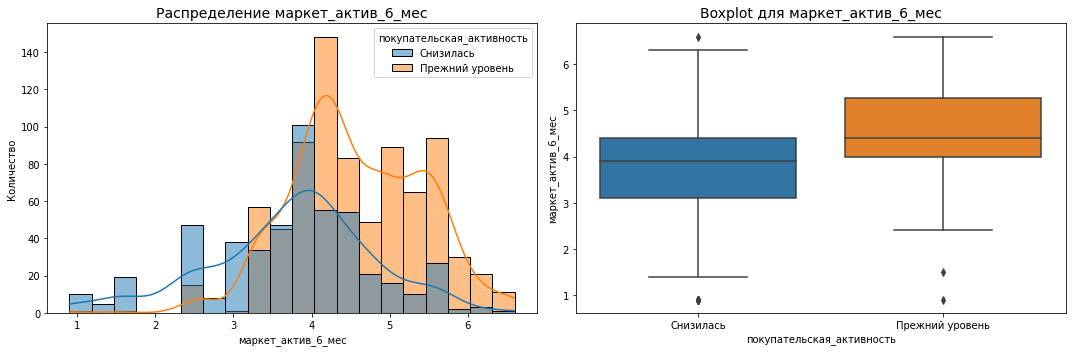

------------------------------------------------------------
📊 Статистика для признака: длительность


count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

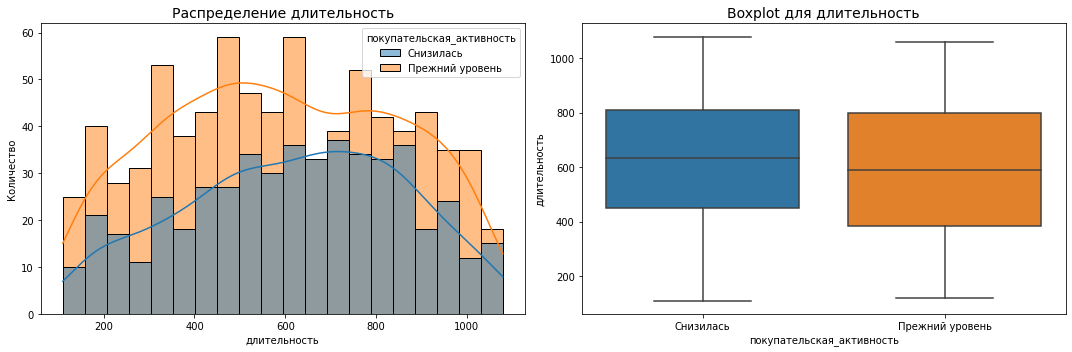

------------------------------------------------------------
📊 Статистика для признака: акционные_покупки


count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

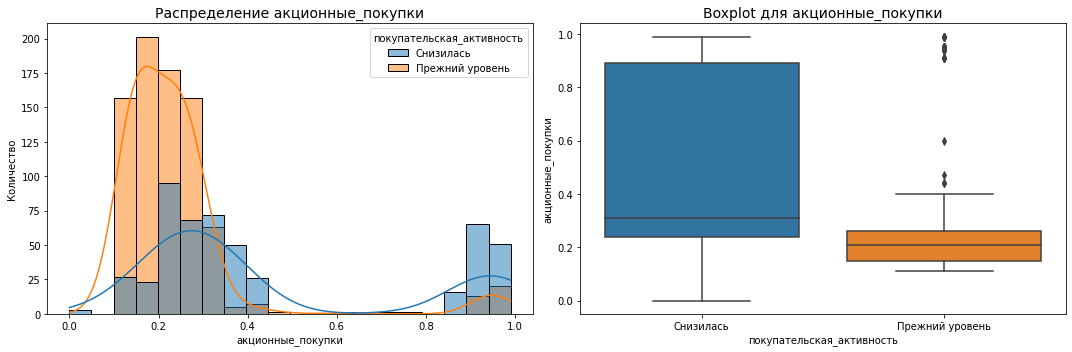

------------------------------------------------------------
📊 Статистика для признака: ошибка_сервиса


count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

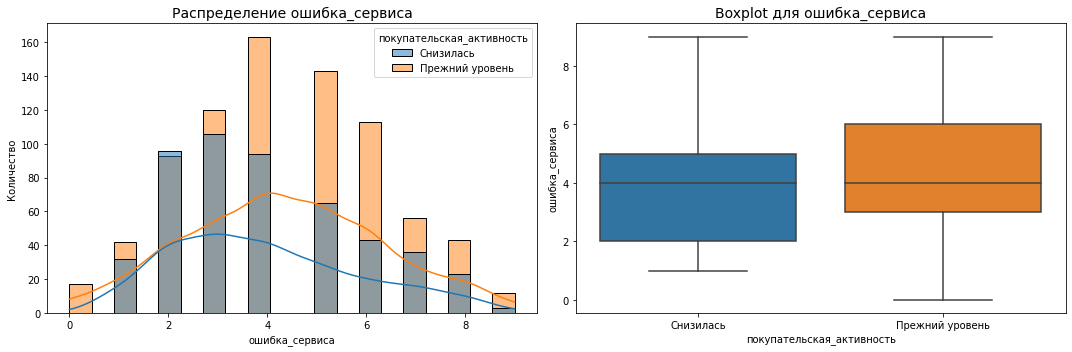

------------------------------------------------------------
📊 Статистика для признака: страниц_за_визит


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

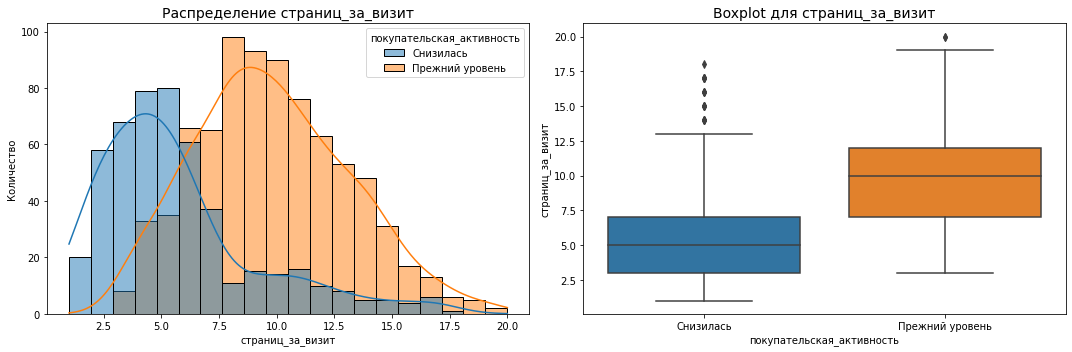

------------------------------------------------------------


In [33]:
#запускаем количественные на основном датафрейме
analyze_numerical_features(market_file, quant_features,'покупательская_активность')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Просто супер: графики подписаны, оси подписаны. Не часто на самом деле такой скрупулёзный подход к оформлению встречается. Молодец! 

Я закончил физико-математический факультет Петрозаводского государственного университета. Нас там с первого курса приучили - если на сдачу лабораторной работы по физике приходишь с графиком, на котором не подписано общее название, названия осей (с единицами измерений), единичная шкала - всё сдача заканчивается не начавшись. Или если у моей лабораторной работы отсутствует вывод: что делали? по какой методике? что "намеряли"? как интерпретировали? какой финальный вывод? - всё, тоже на выход. Ну и в принципе сейчас, на текущей работе: код, который написан в тетрадке мало кому понятен и не сильно кому интересен. Важнее детальные выводы и тренды, которые попадут на слайд презентации в PowerPoint. Именно поэтому столь важное значение в аналитике данных придается промежуточным выводам и уж тем более финальному. 

---
(МЕТОДИЧЕСКИЕ МАТЕРИАЛЫ ПО ОФОРМЛЕНИЮ ГРАФИКОВ):

При работе с графиками важно соблюдать следующие правила:

1. Стоит подписать названия осей X и Y.

2. Также стоит дать название графику.

3. Технические комментарии типа `<AxesSubplot:xlabel='datetime'>` стоит убирать - это можно сделать, поставив точку с запятой в последней строке кода в блоке визуализации, либо сделать последней строкой кода этого блока метод plt.show().

4. Графики нужно сделать больше - графики дефолтного размера не очень удобны для чтения. Удобнее будет настроить параметр plt.rcParams["figure.figsize"] = (x,y) сразу в ячейке импорта библиотек, и все графики проекта будут одного размера.
        
Несколько таких нехитрых приёмов повысят качество твоих визуализаций в проекте. **И здесь следует сказать что ты об правилах оформления всё знаешь! МОЛОДЕЦ!**
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Хотя на графиках подписи есть (об этом похвальный комментарий выше), но я всё-таки хочу обратить твое внимание, что одинаковые "обезличенные" подписи на всех графиках - это не ОК. Графики принято подписывать так, чтобы подписи **отражали суть** изображенного на осях, а также подписи должны содержать и единицы измерения того, что на осях изображено.

Если графики строяться в цикле, то выход такой: вручную создать словарь: "ключ" - название признака по которому на соответствующем шаге будет строиться график, "значения" - список названий ([название графика, название оси ОХ, название оси ОУ]). Далее пробегаем в цикле по названиям признаков (в данных). Сопоставляем название признака с ключом словаря, а названия подписей (графика и 2х осей) берем из соответствующего этому ключу значения.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично!  Боксплот рядом с гистограммой - это отлично! Гистограмма будет показывать нам распределение количественного признака, а боксплот даст информацию о **возможных выбросах** (пишу **возможных**, потому что нужно анализировать бизнесовый смысл значений показанных как выбросы ... просто так удалять то, что показывает боксплот за пределами 1,5 IQR от границ "ящика" - неверно) и основных статистиках (квартилях) признака.
</div>


📊 Статистика по дискретному признаку: маркет_актив_тек_мес


3    308
4    669
5    323
Name: маркет_актив_тек_мес, dtype: int64

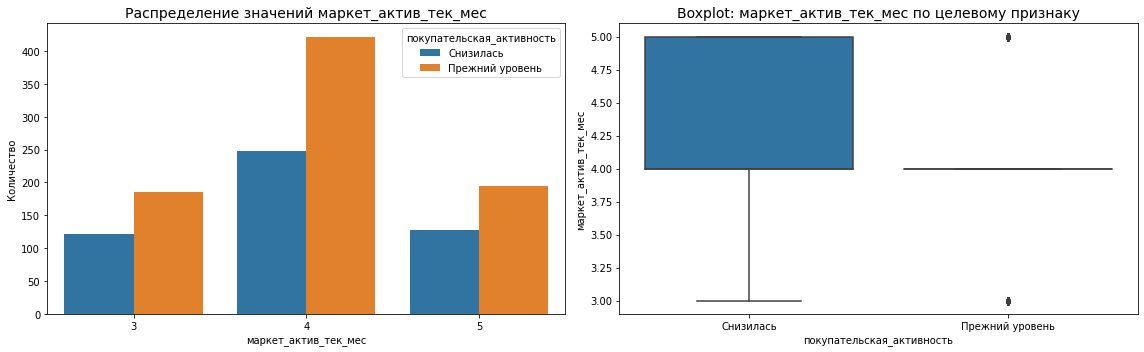

------------------------------------------------------------
📊 Статистика по дискретному признаку: средний_просмотр_категорий_за_визит


1    106
2    312
3    356
4    263
5    177
6     86
Name: средний_просмотр_категорий_за_визит, dtype: int64

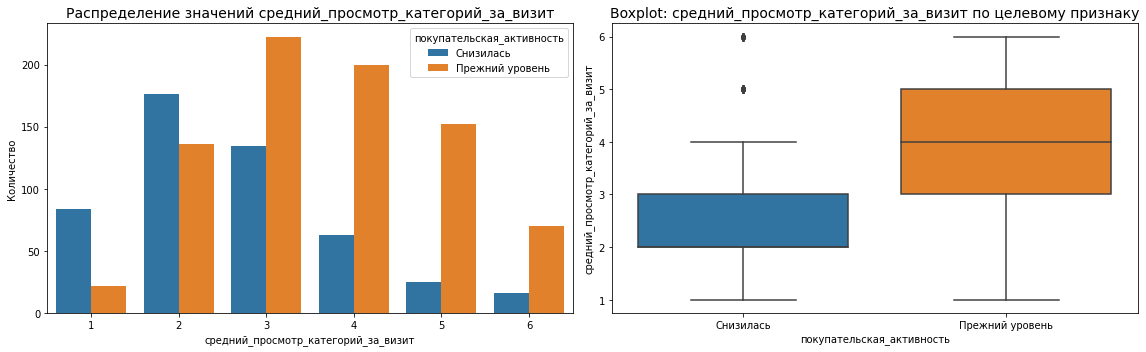

------------------------------------------------------------
📊 Статистика по дискретному признаку: неоплаченные_продукты_штук_квартал


0     116
1     261
2     261
3     218
4     197
5     135
6      44
7      34
8      20
9      10
10      4
Name: неоплаченные_продукты_штук_квартал, dtype: int64

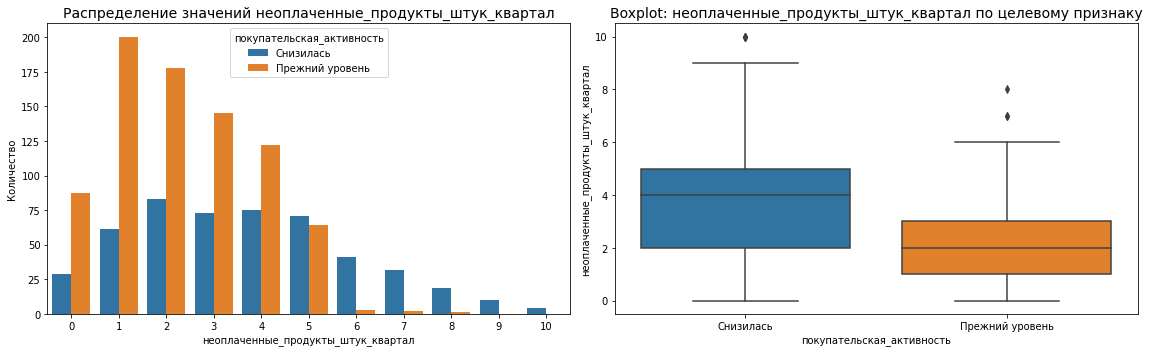

------------------------------------------------------------


In [34]:
# посмотрим теперь на графики
analyze_discrete_features(market_file, discrete_features, target='покупательская_активность')

### Вывод по дискретным признакам: 
- Видно что с клиентами, у которых покупательская активность на прежднем уровне,количество макретинговых коммуникаций за текущий месяц выше.
- Клиенты с актвиной покупательской активностью смотрят больше категорий за визит. Это может быть определенным маркером для бизнеса.
- При этом количество неоплаченных товаров можно расценивать по разному. Однако после 6шт, покупательская активность сильно идет на спад.

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



Ряд признаков в наших данных имеет дискретную природу (например это: 'Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', ... (*не привожу все названия из данных*)). Для графического анализа дискретных признаков нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать **sns.countplot** или **.plot(kind='bar')**. Ты же для визуализации их используешь гистограмму.
    
---
Гистограммы обычно хорошо подходят для визуализации распределения непрерывных числовых признаков. Это могут быть такие признаки, как возраст, доход, количество продуктов в корзине, и т.д. Гистограммы помогают наглядно представить, как значения признака распределены по диапазону.

Для дискретных признаков, особенно если их значения ограничены и могут быть перечислены (например, категории, группы), столбчатые диаграммы или другие методы визуализации, такие как круговые диаграммы или ящики с усами, могут быть более подходящими.

Конечно, если у тебя есть дискретный признак, который принимает большое количество разных значений, и ты хочешь понять их распределение, ты можешь попробовать использовать гистограмму, но при этом учти, что столбцы будут разреженными и могут не давать полного представления о распределении.

**Важно подбирать подходящий тип графика в зависимости от природы данных и целей визуализации.**    
</div>

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Поправил: собрал дискретные признаки, под них перписал функцию, визуализировал, сделал выводы.

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Числовые данные для покупательская_активность:


Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

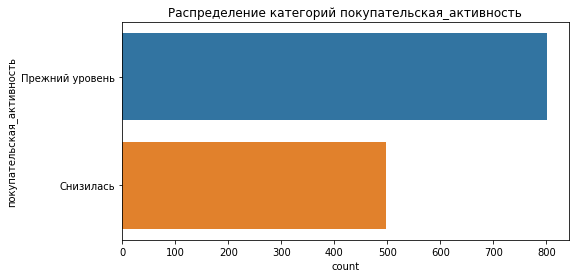

--------------------------------------------------
Числовые данные для тип_сервиса:


стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

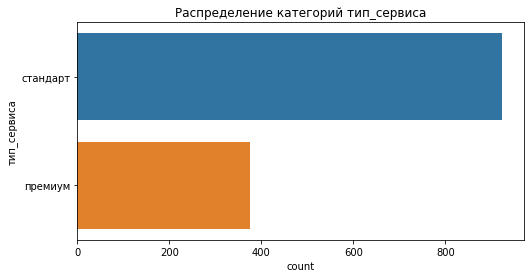

--------------------------------------------------
Числовые данные для разрешить_сообщать:


да     962
нет    338
Name: разрешить_сообщать, dtype: int64

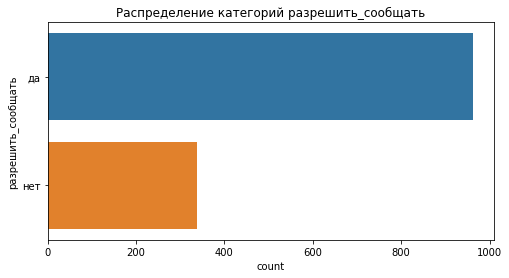

--------------------------------------------------
Числовые данные для популярная_категория:


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

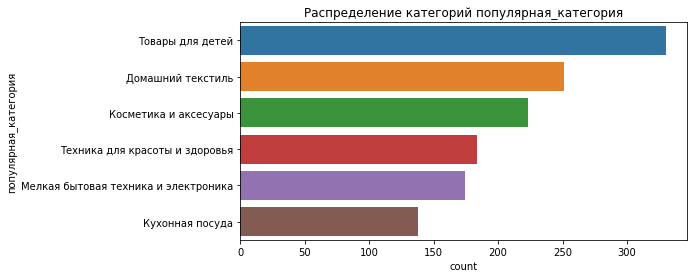

--------------------------------------------------


In [35]:
analyze_categorical_features(market_file, cat_features)


<div class="alert alert-warning">
<b>Комментарий 👉</b>



Наблюдаешь ли дисбаланс в целевой переменной (таргете)? **Если наблюдаешь, то как этот факт отражается на выборке метрики для моделей МО?**
</div>

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Да, он определенно есть. В такому случае, accuracy не подойдет.
Я останавливаю свой выбор на более устойчивой к дисбалансу метрике: ROC-AUC, площадь под кривой) 

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	


Да, верно! Вкратце, только не accuracy ))) Эта метрика в условиях дисбаланса классов ничего о производительности модели не скажет. Почему так? Представим, у нас есть модель, которая обучается на датасете, где 95% примеров принадлежат к классу A, а оставшиеся 5% - к классу B. Если модель просто всегда предсказывает класс A, она достигнет accuracy в 95%, что может показаться впечатляющим результатом.

Однако, с точки зрения решаемой задачи, модель практически бесполезна, потому что она не улавливает примеры класса B. В случае дисбаланса классов, когда один класс сильно преобладает, метрика accuracy может быть высокой даже для моделей, которые не выполняют задачу правильно.

Вместо accuracy в таких случаях рекомендуется использовать другие метрики, такие как:

* Precision (точность): Показывает, какая доля положительных предсказаний верна.

* Recall (полнота): Показывает, какая доля истинных положительных примеров была уловлена моделью. 

* F1-мера: Сочетание точности и полноты.

Матрица ошибок (Confusion Matrix): Позволяет увидеть, какие именно ошибки совершает модель, а не просто общую долю правильных предсказаний.

Эти метрики более информативны в контексте задач с дисбалансом классов, поскольку они учитывают различные аспекты работы модели и ее способность корректно предсказывать оба класса.
</div>


### Теперь market_money.csv

In [36]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

📊 Статистика для признака: выручка


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

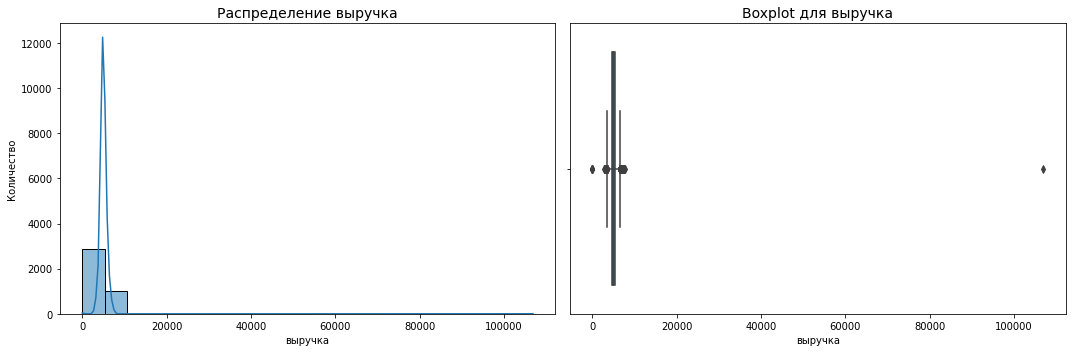

------------------------------------------------------------


In [37]:
analyze_numerical_features(market_money, ['выручка'], target=None)

In [38]:
# Найдем выброс
market_money.query('выручка >10000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [39]:
# Дропаем для точности модели 
market_money = market_money[market_money['выручка'] < 10000]

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, выброс удален!</div>

📊 Статистика для признака: выручка


count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64

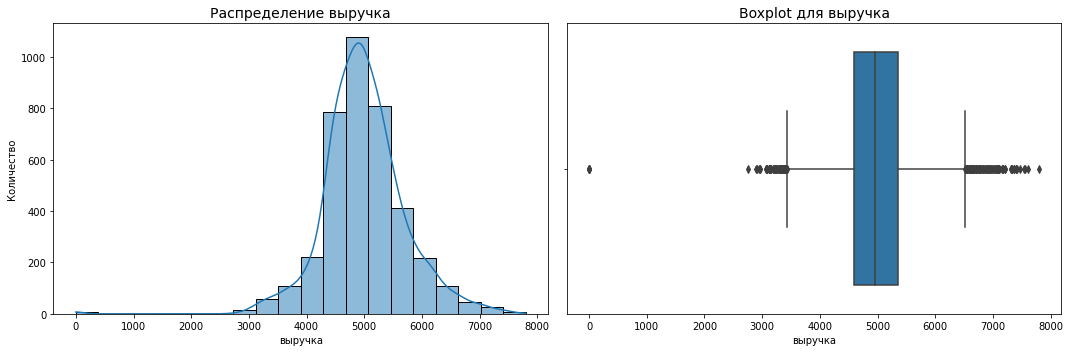

------------------------------------------------------------


In [40]:
analyze_numerical_features(market_money, ['выручка'], target=None)

#### Все не укладывается в межкваритильный размах и есть выбросы у нуля. Но их мы обрежем чуть позже.

### Теперь market_time

In [41]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

📊 Статистика для признака: минут


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

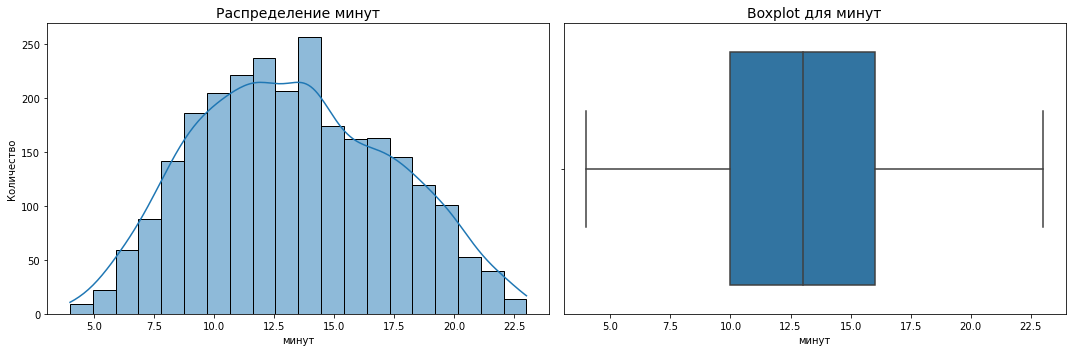

------------------------------------------------------------


In [42]:
analyze_numerical_features(market_time, ['минут'], None)


#### Преимущественно нормальное расределение  с чуть смещенной вершиной, но при этом все данные четко укладываются в межкваритьльный размах.



📊 Анализ признака: маркет_актив_6_мес
Shapiro-Wilk test: stat=0.978, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


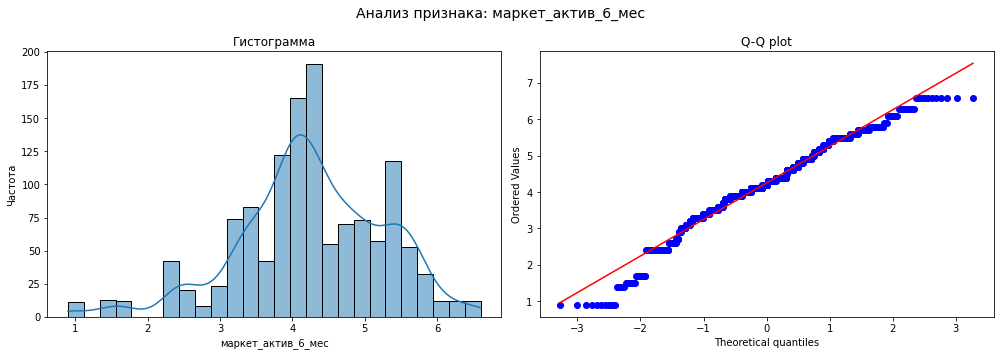


📊 Анализ признака: длительность
Shapiro-Wilk test: stat=0.973, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


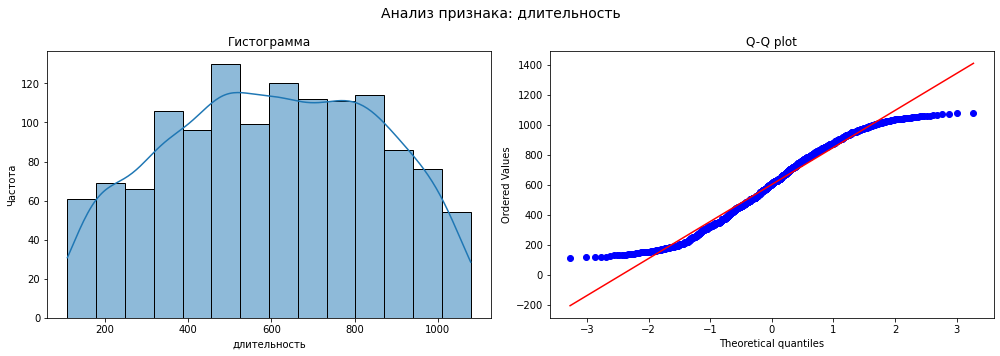


📊 Анализ признака: акционные_покупки
Shapiro-Wilk test: stat=0.662, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


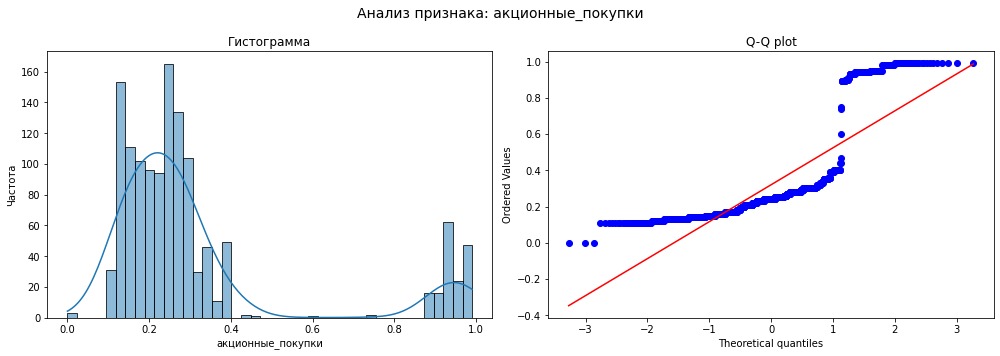


📊 Анализ признака: ошибка_сервиса
Shapiro-Wilk test: stat=0.966, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


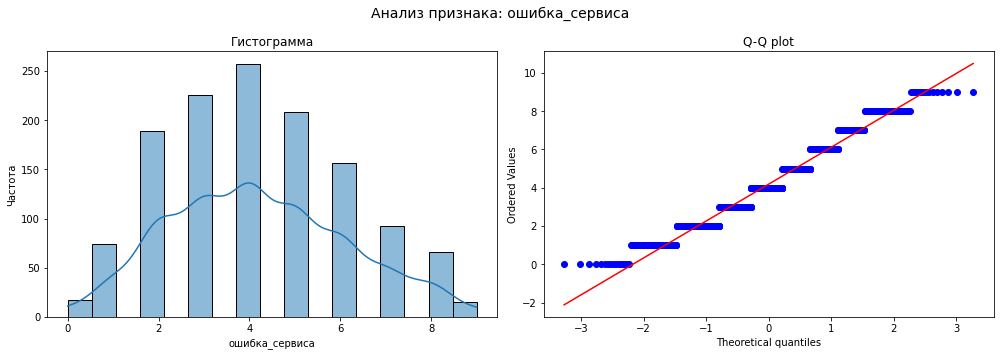


📊 Анализ признака: страниц_за_визит
Shapiro-Wilk test: stat=0.974, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


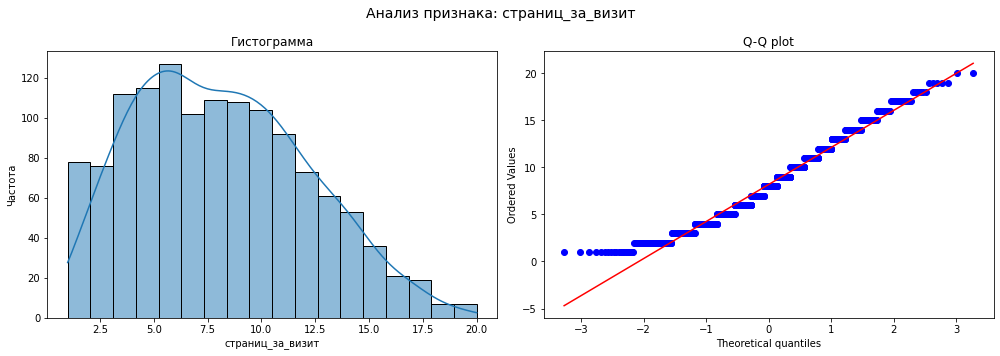

In [43]:
#проведу все тесты рядом с замечанием, что бы удобно было. Первый файл market_file
norm_test_all(market_file,quant_features)


📊 Анализ признака: выручка
Shapiro-Wilk test: stat=0.959, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


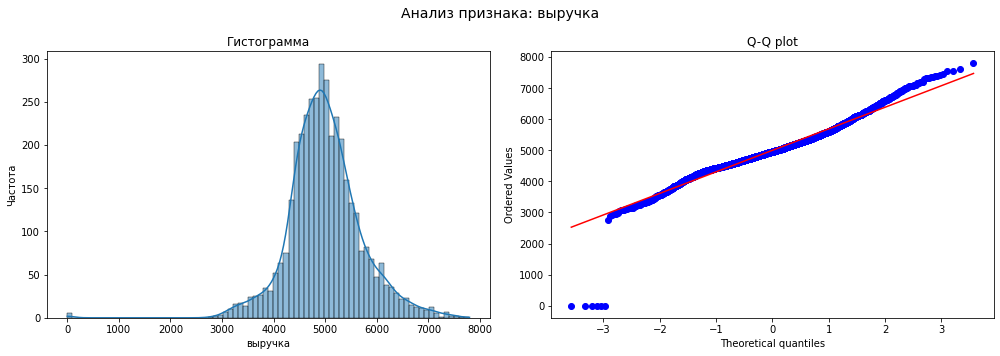

In [44]:
norm_test_all(market_money,['выручка'])


📊 Анализ признака: минут
Shapiro-Wilk test: stat=0.983, p-value=0.000
❌ Распределение отличается от нормального (отвергаем H0)


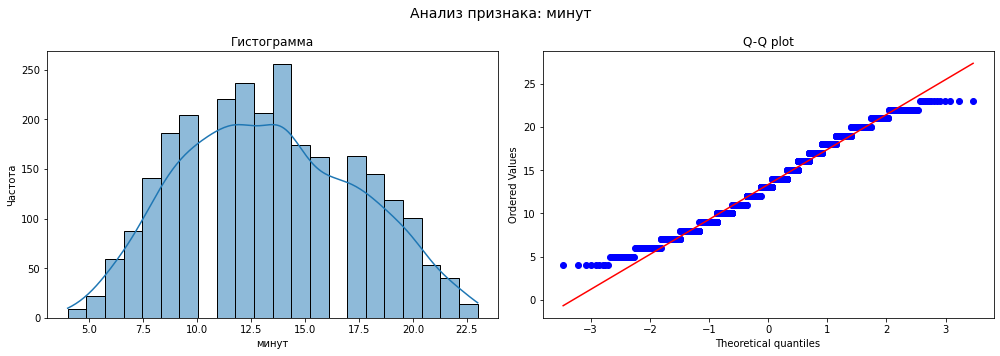

In [45]:
norm_test_all(market_time,['минут'])


📊 Анализ признака: прибыль
Shapiro-Wilk test: stat=0.998, p-value=0.258
✅ Распределение похоже на нормальное (не отвергаем H0)


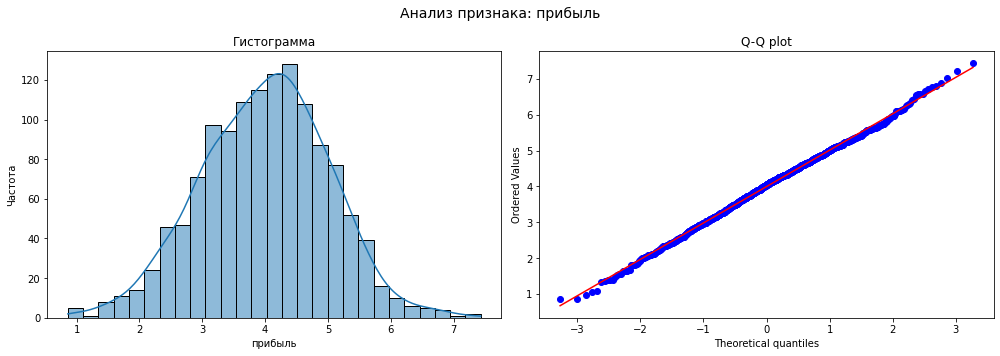

In [46]:
norm_test_all(money,['прибыль'])

### Вывод 
- Только акционные_покупки сильно далеко от значение '1'(че ближе к 1, тем более нормальное распределение)
- Только значение прибыль имеет нормальноераспределение.
- Остальные количественные признаки близки к нормальному распределению. 
- В дальнешем я буду переберать несколько моделей МО для решения задачи, что позволит выбрать лучшую модель.


<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



В наших данных есть признаки с нормальным распределением? Сколько таких признаков?

У нормального распределения не может быть никаких **скосов/смещений/мультимод/ассиметрии/выбросов** - нормальное распределение **АБСОЛЮТНО СИММЕТРИЧНОЕ**.

---
(Не)нормальность распределения данных проверяешь "на глаз", но это некорректно - есть вероятность ошибки (например в случае распределения похожего на Гауссиану). Что надо сделать чтобы строго подтвердить или опровергнуть нормальность распределения случайной величины?

Вот полезные материалы материалы на эту тему: https://education.yandex.ru/handbook/data-analysis/article/bazovye-statisticheskie-testy и https://education.yandex.ru/handbook/data-analysis/article/bazovye-statisticheskie-testy-v-python
</div>

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Пришлось добавить еще одну функцию и перебрать все датасеты и их признаки.
В других работах такой анализ я не проводил, перечитал/переискал такое тестирование в лекциях - тоже не нашел.
Но анализ я провел)

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>
    
**Пришлось добавить еще одну функцию и перебрать все датасеты и их признаки** - здесь всё отлично теперь. Спасибо за "строгую" проверку.    

**перечитал/переискал такое тестирование в лекциях - тоже не нашел** - Александр, а модуль по статистике у вас уже был в Тренажере?
</div>

### Теперь money

📊 Статистика для признака: прибыль


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

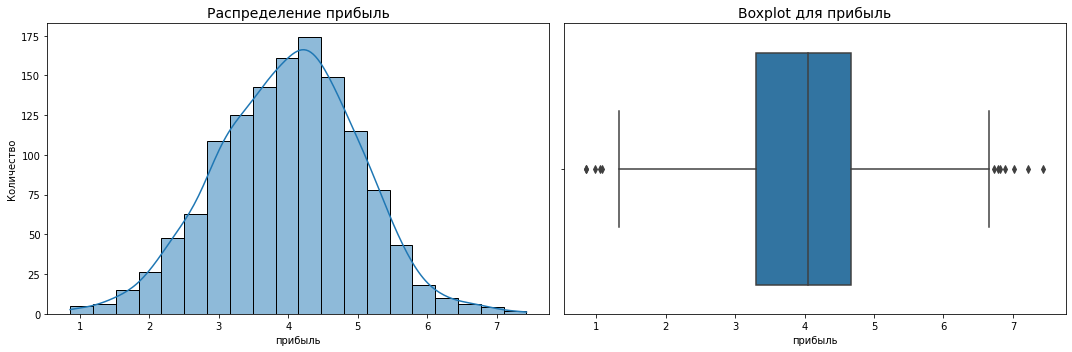

------------------------------------------------------------


In [47]:
analyze_numerical_features(money, ['прибыль'], None)

#### Преимущественно нормальное расределение, есть выбросы, но мы пока их оставим.

###  Теперь отберем клиентов с  покупательской активностью не менее трёх месяцев. Исходя из данных датасетов, это клиенты, которые есть в market_money, так как там всего 3 временных критерия: 'препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц' и у которых в каждом месяце есть выручка.


In [48]:
market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [49]:
# можем дропать их
market_money = market_money[market_money['выручка'] > 0]

In [50]:
# Посчитаем количество месяцев с выручкой > 0 для каждого клиента
active_clients = (
    market_money
    .groupby('id')['период']
    .nunique()
    .reset_index(name='active_months')
)

In [51]:
# Теперь отберем клиентов у которых она равна 3м
active_clients = active_clients[active_clients['active_months'] == 3]

In [52]:
active_ids = active_clients['id']

In [53]:
# Обновим основной файл
market_file = market_file[market_file['id'].isin(active_clients['id'])]

In [54]:
len(market_file)

1296

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Супер! Здесь молодец, НЕ УПУСКАЕШЬ требование брифа в части обработки покупателей НЕ имеющих полной покупательской истории в крайние 3 месяца:
    
</div>

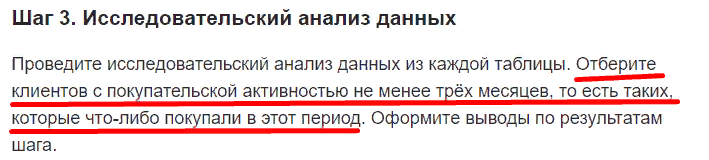

#### Вывод:
- Познакомились с данными визуально, как с категориальными, так и с количественными. 
- Распределения нормальные, подозрений не вызывают. Хотя есть местами выбросы. 
- Убрали трех клиентов, у которых покупательская активность менее трех месяцев и один явный выброс. 


#### Обновленный вывод: 
#####  Характеристики клиента
- 

#### Поведение
- *длительность* - визуально нет различий.
- *акционные_покупки* - есть ощутимый скачок у категории со снижением активности в сторону акционных покупок. Явно ощущается, что пользователи, у которых снизилась активность покупают только по акции.
- *средний_просмотр_категорий_за_визит* - мода = значению 3. Все что меньше - в зоне риска, все что больше - там активность на прежднем уровне.
- *страниц_за_визит* - четко прослежтвается, что покупатели с высоким уровнем активности, посещают больше страниц. В то же время, покупатели со сниженной активностью, посещают в основном, не  более 5 страниц. Хороший маркер по снижению активности. 
#### Покупки
- *неоплаченные_продукты_штук_квартал* - наблюдается, что чем больше покупок неоплаченно, тем ниже активность. При этом даже у тех пользователей, у которых активность на прежднем уровне, есть до 5 товаров в квартал неоплаченных. С этим можно поработать: уведомления, геймификация. 
- *популярная категория* - самая популярная - товары для детей, самая непопулярная - кухонная посуда. 
#### Проблемы
- *ошибка_сервиса* - самое частое значение 4, распредленеи по катагориям пропроциональное. Но я считаю что ошибок много, есть с чем работать. 
#### Маркетинг 
- *маркет_актив_6_мес* - стоит обратить внимание, что с теми покупателями у кого снизилась, взаимодействий за период менее 4
- *маркет_актив_тек_мес* - как-будто одинаковое распределение. Это дает рассуждения о том, что взаимодействовать надо вдолгую, а не только в текущем месяце.


<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Собрал выводы понятные бизнесу.

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Отлично! Исправлено.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Финального вывода по исследовательскому анализу данных (EDA) нет.
    
Визуализация 15+ признаков выполнена, но **бизнесовых выводов** по графикам нет. Как могли бы выглядеть такие выводы? Бизнесу какая польза оттого что просто графики построены?

Как могли бы выглядеть такие выводы? Ну например так:
</div>

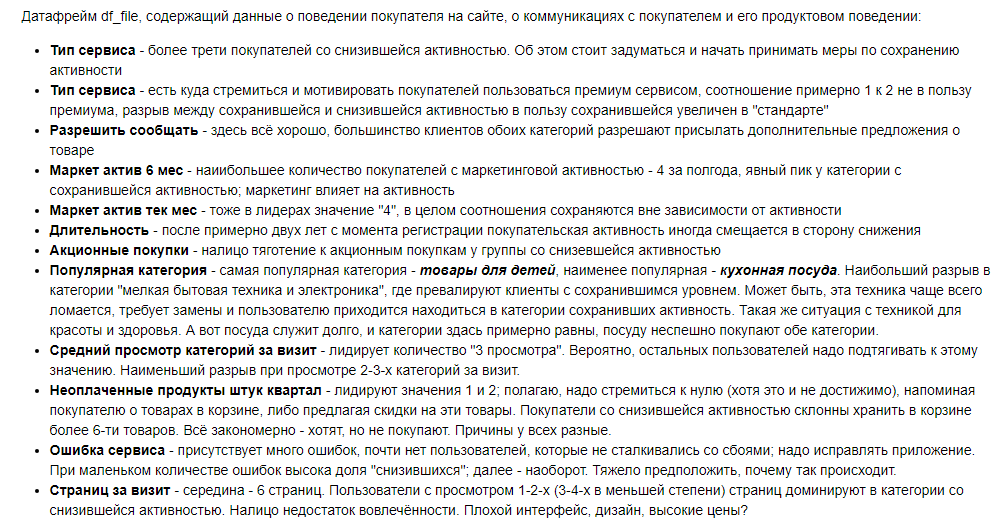

<div class="alert alert-warning">
<b>Комментарий 👉</b>

**Этот шаг спасет твою аналитику (и карьеру):** классический кейс - к аналитику (неважно: DA-аналитику, DS-аналитику, ML-инженеру) прибегает его начальник с горящими глазами: «Срочно нужно посчитать метрики, отчет нужен вчера, Я ЖДУУУУУУУУ!!!!!!!!!!!!!!!!!!!!!!». Аналитик лезет в сырые данные, быстро собирает дашборд … и всё. Ни тебе проверки распределений, ни поиска выбросов, ни визуализации. Начальник на следующий день презентует эти цифры как истину в последней инстанции. А потом на них строятся бизнес-решения стоимостью десятки-сотни миллионов рублей … 

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>ТАК ДЕЛАТЬ НЕЛЬЗЯ! НИКОГДА!!!</u></summary>

Исследовательский анализ данных (EDA — Exploratory Data Analysis) — это первый и обязательный шаг перед тем, как ты начнёшь считать метрики, строить модели или делать выводы. Он помогает понять, с чем ты на самом деле работаешь, выявить ошибки и аномалии, а самое главное, не попасть в ловушку красивых, но ложных цифр.

Особенно критично это в машинном обучении. Когда ты обучаешь модель на плохих данных, хороший результат невозможен в принципе. В этом смысле работает железное правило: garbage in — garbage out.

Что входит в EDA?

✔️ Осмотр данных. Сколько строк? Какие типы колонок? Что выглядит странно? Уже на этом этапе можно поймать очевидные ошибки. Используй .info(), .describe(), загляни в начало и конец таблицы, проверь типы.

✔️ Пропуски и дубликаты. Пропуски не всегда нужно удалять — иногда лучше заполнить их медианой, модой или предсказанными значениями. А дубликаты — это не только точные копии строк. Часто бывают неявные: например, у одного пользователя два одинаковых заказа с разными ID.

✔️ Очистка и предобработка. Проверка категориальных значений, работа с форматами, единообразие записи. Например, если у тебя в колонке есть и «Санкт-Петербург» и «СПБ» и «Питер», то без нормализации это три разных значения. А если даты хранятся как строки — ты не сможешь нормально их анализировать.

✔️ Выбросы и аномалии. Просто посчитать среднее недостаточно. Построй распределение, используй boxplot. Эти графики мгновенно покажут, где данные выбиваются за границы нормы. И не забывай: один выброс может испортить тебе весь анализ.

✔️ Визуализация. Даже простой scatter plot может рассказать тебе гораздо больше, чем набор агрегатов. Иногда взаимосвязь между переменными становится очевидной только когда ты её увидишь, а не посчитаешь.

EDA — это не про «поковыряться в данных». Это про понять, что ты анализируешь, и быть уверенным в своих выводах. Это защита от ошибок, которые ты даже не успел заметить.

Теперь давай разберём первый и самый недооценённый шаг в исследовательском анализе: осмотр данных.

Представь, что ты лезешь в базу и ... сразу пишешь groupby() или строишь график? Это ловушка. Начинать нужно не с расчётов, а с банального знакомства с тем, что у тебя вообще в руках. Осмотр данных — это как включить свет в темной комнате. Сразу видно, где пыльно, а где стоит тумбочка, об которую легко споткнуться.

Первым делом смотри на объем данных: df.shape покажет, сколько строк и колонок. Иногда там вообще пара десятков строк — и это уже повод позвать дата-инженера. 
Дальше — названия колонок. Через df.columns можно заметить лишние пробелы, странные символы, дубли названий. Здесь же удобно сразу стандартизировать названия: убрать русские слова и привести к единому стилю ("snake_case" ван лав). Такие вещи не бросаются в глаза, но потом ломают пайплайн.

Теперь — в бой идет df.info(). Это твой лучший друг. Он покажет:

▪️какие типы данных у колонок,
▪️сколько ненулевых значений,
▪️сколько памяти жрёт датафрейм.

Обрати внимание: если в колонке написано, что у неё 80 000 непустых значений, а в df.shape[0] у тебя 100 000 — значит, 20% пропусков. Это серьёзно. 
Ещё один лайфхак: если колонка выглядит пустой, но info() говорит, что там всё заполнено — проверь, не строки ли там вроде " " или "None". Это визуальные, а не настоящие пропуски. Так что df.replace() тебе в помощь.

Если всё типы данных соответствуют ожиданиям — отлично. Если нет — можно наткнуться на неприятности. Например, object вместо чисел или дат — и ты не сможешь нормально группировать, фильтровать, делить на категории. В таких случаях сразу меняй тип или уточняй источник.

Следом подключай df.describe(). Это быстрый способ понять, как «живут» числовые данные. Сравни среднее и медиану — это может подсветить асимметричное распределение. Проверь минимум и максимум — там часто сидят выбросы или ошибки: отрицательные значения там, где их быть не должно, нули в колонке с деньгами, тысячи категорий у рейтинга от 1 до 5.

Дополнительно пригодится .nunique(): иногда колонка кажется категориальной, а там каждый второй элемент уникален. Это уже почти ID, и скорее всего — не то, что ты хотел анализировать.

И не забывай смотреть глазами. df.head(), df.tail() — быстрый способ поймать неявные проблемы. Например, даты, которые лежат строками. Или списки внутри ячеек. Или дубли с разницей в один символ. В табличке может быть много неожиданного — особенно если её собирали в два этапа, три человека, а выгружал четвёртый.

Осмотр данных — это про внимательность и здравый смысл. Здесь ты ловишь грубые баги, структурные проблемы и мусор, который может незаметно утащить твою аналитику не туда. А ещё — экономишь себе кучу времени, потому что не придется всё переделывать после того, как уже построен отчёт.

</details>
<br>
<br>
</div>


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Данные загружены, отлично.

Хорошо, что применяешь метод .head()/.sample() таким образом в память не будет загружен весь датасет, объем которого может быть огромным.

Методы .info, .describe, .value_counts(), .unique() как правило часто встречаются и обязательны к применению в задачах по исследованию данных, ведь с их помощью можно получить первые инсайты. 

Итак, мы провели предварительный анализ данных, проверили данные на наличие пропусков и затем обработали их (аргументированно заполнили / удалили / оставили как есть). Провели графический анализ. Сделали и озвучили выводы. Теперь можно приступать собственно к моделированию и ответам на вопросы проекта.

</div>

## Объединение таблиц

In [55]:
# групируем первый датасет по id и переиоду
market_money_grouped = market_money.pivot(index='id', columns='период', values='выручка')
market_money_grouped = market_money_grouped[['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']]
market_money_grouped.columns = ['выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']

In [56]:
# теперь второй
market_time_grouped = market_time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index


In [57]:
# теперь собираем воедино:
market_full = market_file.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,id_минут
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,215349
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,215350
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,215351
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,215352
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,215353


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, отлично! Из "длинного" датафрейма сделали "широкий". Ровно то, что и требуется:
    
</div>

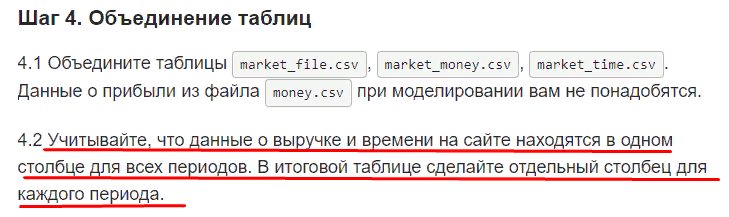

#### Вывод: 
- Мы создаем общую сводную таблицу где мастер-записью является id клиента, а каждая колонка это один из периодов выручки.
- Так же поступаем с таблицей где есть учет времени проведенного на сайте пользователем. 
-  Далее объединяем это все в один датасет.

In [58]:
market_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,id_минут
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,215349
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,215350
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,215351
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,215352
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,215353


<div class="alert alert-warning">
<b>Комментарий 👉</b>

В случае объединения/слияния датафреймов рекомендую тебе смотреть на размерости датафреймов ДО слияния и ПОСЛЕ него. В подобных операциях часто ошибки бывают.
</div>

##  Корреляционный анализ

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Смотришь скоррелированность признаков - отлично! Об этом чуть ниже подробней напишу....

---
p.s. присмотрись к библиотеке phik! Она (Phi_K correlation) представляет собой инструмент для вычисления и визуализации корреляции между категориальными и количественными переменными. Она может быть полезной в анализе данных перед построением моделей машинного обучения, так как позволяет обнаружить скрытые взаимосвязи между переменными, которые могли бы остаться незамеченными при обычных методах корреляционного анализа.
Преимущества использования **phik**:

1. **Учет категориальных переменных**: Традиционные методы вычисления корреляции, такие как коэффициент корреляции Пирсона, применяются только к количественным переменным. phik позволяет вычислять корреляцию между категориальными и количественными переменными, что делает его мощным инструментом для анализа разнообразных типов данных.

2. **Обнаружение нелинейных зависимостей**: phik способен обнаруживать нелинейные связи между переменными, которые могли бы быть упущены традиционными методами. Это особенно важно в анализе данных, где зависимости могут быть сложными и нелинейными (что может влиять на твой выбор признаков для моделей МО).

3. **Подходит для больших наборов данных**: phik обладает хорошей масштабируемостью, что позволяет использовать его для анализа больших наборов данных без серьезного снижения производительности.

4. **Визуализация результатов**: Библиотека предоставляет инструменты для визуализации матрицы корреляции между переменными, что помогает лучше понимать зависимости в данных.

Вот пример кода, как использовать phik для вычисления корреляции:
    
    # Установим "руками", если не установлена
    !pip install phik -q

    # Импортируем
    import phik
    import pandas as pd

    # Загрузка данных
    data = pd.read_csv('data.csv')

    # Вычисление матрицы корреляции с использованием phik
    corr_matrix = data.phik_matrix(interval_cols= ...)

    # Визуализация матрицы корреляции
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Phi_K Correlation Matrix')
    plt.show()

p.s. при использовании **phik** крайне важно настроить параметр **interval_cols**, передав ему список с названиями **непрерывных признаков**: если этого не сделать, библиотека своими силами будет пытаться разнести признаки по типам, и она зачастую делает в этом ошибки - от этого в свою очередь мы получаем некорректную оценку корреляций, так как от типа признака зависит метод оценки корреляции.

p.p.s. у этой библиотеки есть ограничение с которым я например сталкивался: когда в даных есть столбцы с очень большим количеством уникальных значений, то phik может "упасть" с сообщением об ошибке (суть которого в том, что не хватает памяти для обработки такого количества "уников"). ПРи этом на компьютере у меня 32 Гб памяти и большая часть её не занята. Я подозреваю что это некое внутреннее ограничение библиотеки.
</div>

### Сначала посмотрим общую матрицу корреляции. 
- Устраним мультиколлинеарность(при коэффиценте выше 0.8)
- Удалим некоррелирующие с целевым признаки
- Сделаем выводы перед машинным обучением. 

In [59]:
# выделим только количественные, убрав id и целевой
numeric_features = market_full.select_dtypes(include='number').drop(['id'], axis=1)


In [60]:
numeric_features = numeric_features.drop('id_минут', axis=1)

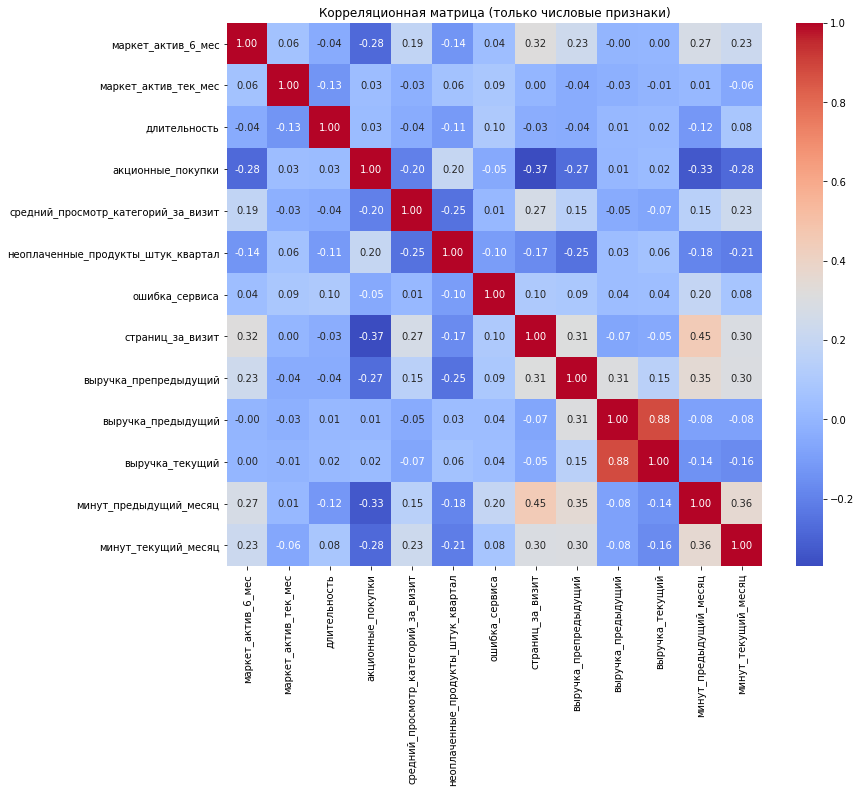

In [61]:
# строим корреляционную матрицу с учетом рекомендации
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица (только числовые признаки)')
plt.show()


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Да, понимание структуры данных дает нам основание использовать метод Спирмена/Кендалла, а не Пирсона (при оценки степени корреляции признаков).

Присоединяю табличку в помощь (и для последующих повторных обращений к ней):
</div>

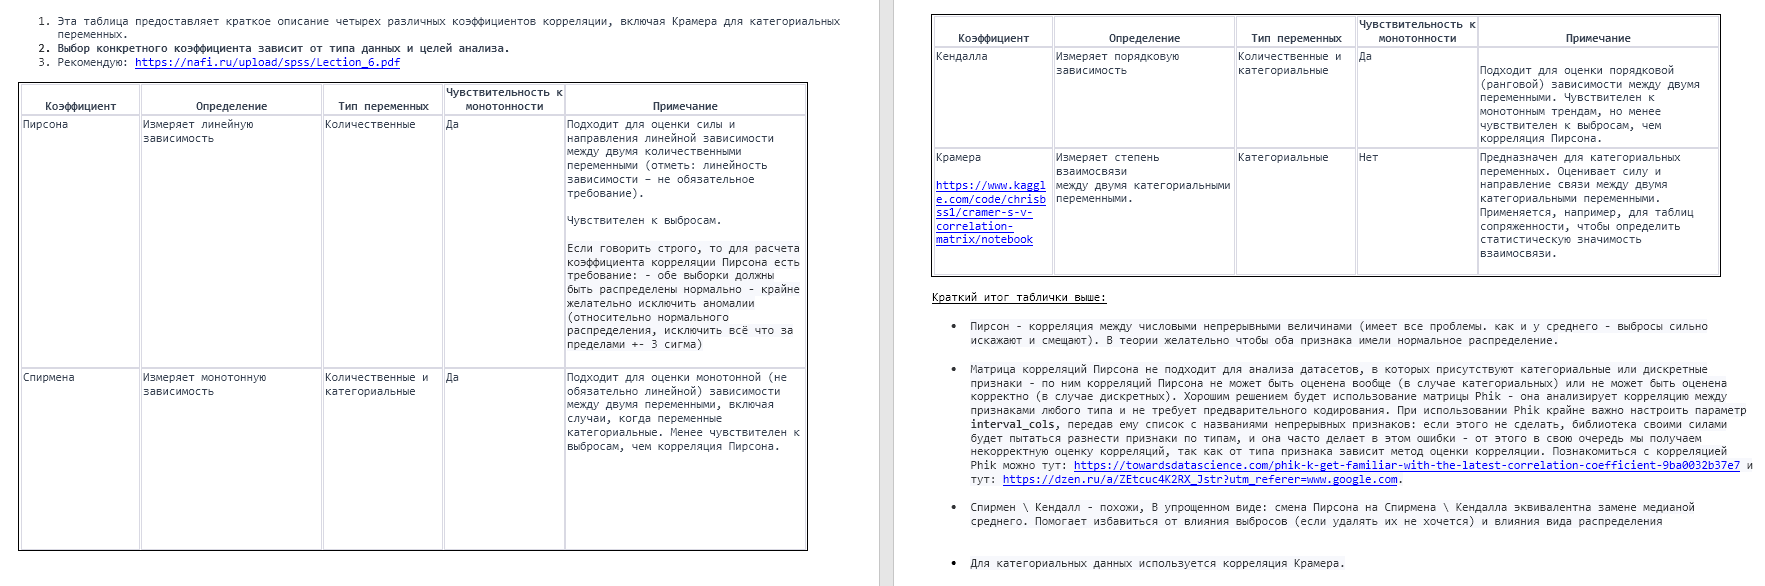
    
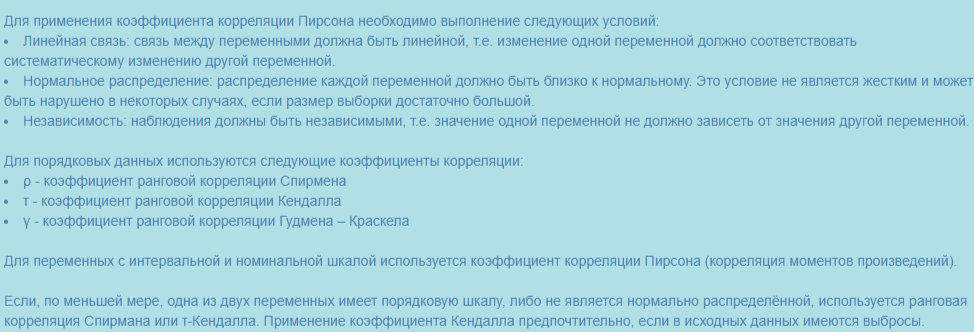    

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


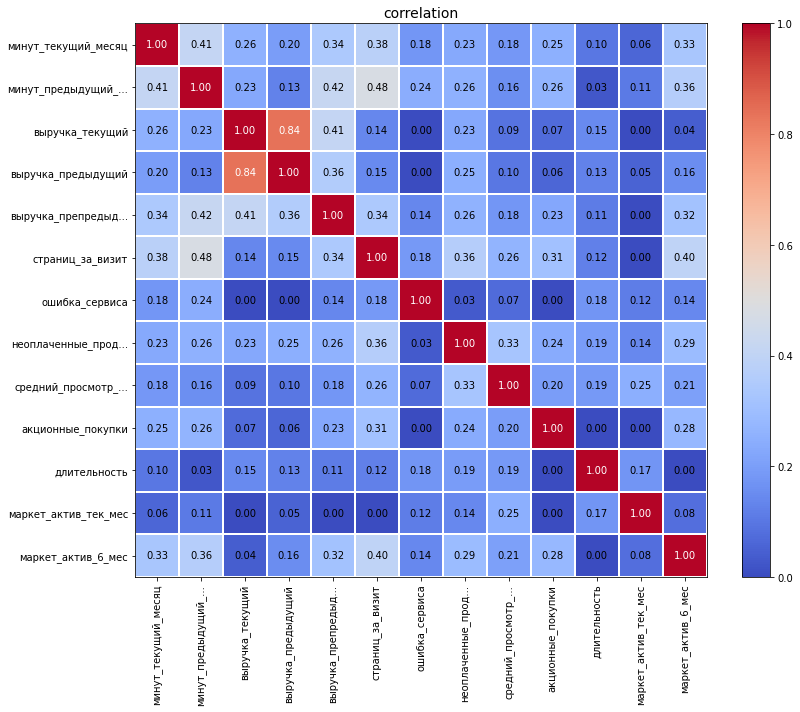

In [62]:
#попробуем по рекомендации через phik

phik_matrix = numeric_features.phik_matrix()
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        figsize=(12, 10), 
                        vmin=0, vmax=1, color_map='coolwarm')

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

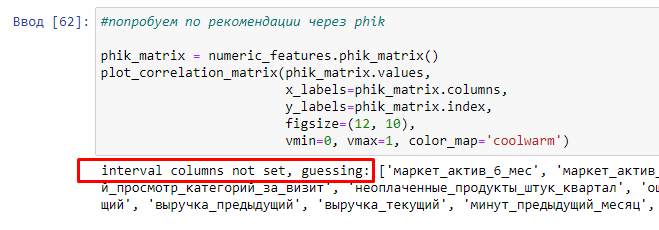

При использовании **phik** крайне важно настроить параметр **interval_cols**, передав ему список с названиями **непрерывных признаков**: если этого не сделать, библиотека своими силами будет пытаться разнести признаки по типам, и она зачастую делает в этом ошибки - от этого в свою очередь мы получаем некорректную оценку корреляций, так как от типа признака зависит метод оценки корреляции.

**ВАЖНО: прошу тебя аналогичные моменты исправить и ниже (если подобные ошибки встречаются), но уже самостоятельно**.</div>

### Вывод по корреляции:
- Большой корреляции, которую необходимо удалить нет ни в корреляции Спирмана, при использовании phi-корреляции. 

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Признаки распределены не нормально, но близко, это я доказал пункте 3.6
По рекомендации использовал несколько вариантов: Используя коэффицен корреляции Спирмена.
Ипользя библиотеку phik




<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



Нормально ли распределены наши признаки? Если нет, то каким методом надо считать коэффициенты корреляции?
    
Небольшая напоминалка на скрине: Пирсон - это дефолтный метод.
</div>

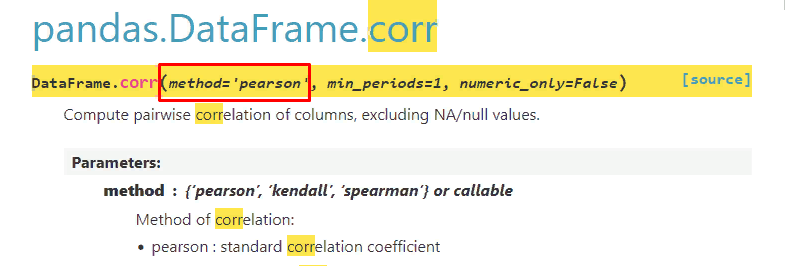

In [63]:
# Видим что действительно большой коэффицент получился только у признаков : 'выручка_текущий','выручка_предыдущий'
# он равен: 0.84. Можем удалить его для большей точности модели. Удалим предидущий, так как он дальше от событий реального времени. 
#market_full = market_full.drop('выручка_предыдущий', axis=1)

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несколько моментов "на будущее" (сейчас забегаю чуть вперед, но будущем это будет важно) которые я хотел озвучить перед переходом к собственно исследованию (некоторые из этих моментов в твоем проекте реализованы):
    
- имеет смысл критично посмотреть на данные с точки зрения наличия пропусков в признаках (вопрос: все ли ml-модели "любят" пропуски?) и обработать или удалить их 
    
- имеет смысл явно обозначить какую задачу мы будем решать: с учителем / без учителя, классификации / регрессии ...
    
- в моделях бинарной классификации (это ровным счётом наш случай!) имеет смысл смотреть на баланс классов. Два взгляда (с разных сторон) на эту проблему тут: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/ и https://habr.com/ru/post/349078/
    
- имеет смысл смотреть на корреляцию признаков. При высокой их степени коррелированности возникает проблема  мультиколлиниарность признаков. Проблема "мультиколлинеарности" это и про переобучение модели и про её интерпретируемость и про сложность модели (содержание в модели избыточного количества переменных). В чем негативный эффект сложной модели? Вот в чем: усложняется интерпретация параметров, оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Вот несколько причин, почему проблема мультиколлинеарности (МК) важна:

1. Неоднозначность коэффициентов: МК делает оценку коэффициентов модели неустойчивой. Когда существует сильная корреляция между признаками, модель становится неспособной разделить влияние каждого признака на целевую переменную. Это может привести к неоднозначным и неправильным оценкам коэффициентов, что затрудняет интерпретацию важности каждого признака. Согласись - это важно, чтобы результат, который выдает модель можно было бы понять и объяснить с точки зрения предметной области. В случае включения в модель высокоскоррелированных признаков - может случиться так, что коэффициенты (да, проблема присуща моделям линейным ... регрессия среди них!) могут менять знаки и попытка объяснения предметной области с помощью этих коэффициентов будет противоречить здравому смыслу.

2. Плохая обобщающая способность: МК может снизить способность модели обобщаться на новые данные. Когда сильно коррелированные признаки присутствуют в модели, модель может стать "перегенерированной" и склонной к переобучению на обучающих данных. В результате модель может показывать хорошую производительность на обучающих данных, но плохо обобщаться на новые данные.

3. Ухудшение точности и устойчивости модели: МК может привести к численным проблемам при решении линейных уравнений, используемых для оценки коэффициентов модели. Это может привести к нестабильности и неточности оценок. Кроме того, небольшие изменения в данных могут привести к большим изменениям в оценках коэффициентов модели, что делает модель неустойчивой.

4. Избыточность информации: Когда признаки сильно коррелированы, они предоставляют практически одинаковую информацию о целевой переменной. Такая избыточность может привести к неэффективности модели и увеличению сложности модели без значительного улучшения производительности.

В целом, МК может иметь отрицательное влияние на производительность, стабильность, интерпретируемость и обобщающую способность.
    
---
Для деревянных моделей и моделей градиентного бустинга проблема МК  не является такой критической, как для линейных моделей. Вот несколько причин:

1. Нелинейность: Деревянные модели и модели градиентного бустинга являются нелинейными моделями. Они способны обрабатывать сложные взаимодействия между признаками и целевой переменной. В отличие от линейных моделей, они могут более гибко адаптироваться к наличию мультиколлинеарности в данных.

2. Рекурсивное разбиение: Деревья принятия решений в деревянных моделях и моделях градиентного бустинга используют рекурсивное разбиение для разделения данных на более чистые группы. Это означает, что деревья могут независимо выбирать разные признаки для разделения, даже если они сильно коррелированы. Таким образом, деревья могут игнорировать мультиколлинеарность и использовать другие признаки для принятия решений.

3. Ансамбль деревьев: Модели градиентного бустинга строятся на основе ансамбля слабых деревьев решений. Каждое дерево добавляется постепенно для уменьшения ошибки предыдущих деревьев. Это позволяет модели градиентного бустинга восстанавливать ошибки, вызванные мультиколлинеарностью, поэтапно улучшая прогнозы.

Хотя мультиколлинеарность не является проблемой в деревянных моделях и моделях градиентного бустинга в той же степени, что и в линейных моделях, она все еще может оказывать влияние на производительность и интерпретируемость модели. Сильно коррелированные признаки могут вносить избыточность в модель и увеличивать сложность, не принося значительного улучшения в прогнозах. Поэтому, хотя деревья могут быть более устойчивыми к мультиколлинеарности, все же рекомендуется выполнять анализ корреляции признаков и, при необходимости, применять методы снижения размерности или регуляризации для улучшения модели.
    
Вот классная статья. Простым языком, на примере показана проблема. А также, что важно - разобраны варианты как её (проблему) победить. Статья: https://habr.com/ru/company/akbarsdigital/blog/592493/ 
    
</details>
<br>
<br>    
</div>

##  Использование пайплайнов

### Будем использовать изученные ранее модели:
- Модель логистической регрессии
- Метод опорных векторов
- Метод k-ближайших соседей
- Дерево решений

### План
- Закодируем целевой признак - покупательская_активность.  
- Сделаем из акционных покупок - категориальный признак.
- Разделим данные на тренировочную и тестовую выборки.
- Подготовим данные: отдельно обработаем количественные, отдельно категориальные. 
- Масштабируем данные
- Обучим модель, посмотрим метрики, выберем самую эффективную модель.


#### Кодируем целевой и делаем категориальный из акционного

In [64]:
#market_full['активность_bin'] = market_full['покупательская_активность'].map({
#    'Снизилась': 0,
#    'Прежний уровень': 1
#})

In [65]:
# Добавляем LE и применяем
target_encoder = LabelEncoder()
market_full['активность_bin'] = target_encoder.fit_transform(market_full['покупательская_активность'])


<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>
    Поправил в соответсвии с рекомендацией.


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>


Кодирование таргета нельзя делать "руками":

- при появлении новых значений категориальных признаков, не предусмотренных твоим решением, модель или упадёт, или будет генерировать ошибки;
- такое решение не сделаешь частью пайплайна, а все современные решения базируются на них.
    
Поэтому кодирование нужно делать только с применением обучаемых трансформеров. Для кодирования целевого признака нужно использовать LabelEncoder (сокращаю до LE): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html.

p.s. если стоит вопрос в том, что тебе не нравиться, что LE, например, присваивает классу "снизилась" метку 0, а "прежний уровень" - метку 1, то значения меток можно инвертировать с помощью небольшого лайфхака:

        import numpy as np

        # Пример преобразованных классов
        target = np.array([0, 1, 1, 0, 1, 0])

        # Инвертирование классов
        inverted_target = 1 - target

        print("Исходные классы:", target)
        print("Инвертированные классы:", inverted_target)

В этом примере переменная inverted_target будет содержать те же значения, что и target, но значения будут инвертированы.

p.p.s. есть ещё метод invert_transform()
</div>

In [66]:
market_full['активность_bin'].sample(5)

115     1
62      1
334     1
1044    0
849     0
Name: активность_bin, dtype: int64

In [67]:
market_full['акционные_покупки_категория'] = market_full['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
market_full = market_full.drop(['акционные_покупки'], axis=1)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец что занимаешся фиче-инжинирингом! Редко такое вижу в проектах коллег, но знаю, что это именно то, что способно дать буст метрикам твоих моделей.
    
Генерация новых признаков в данных - это важный и эффективный способ улучшить производительность моделей машинного обучения. Это позволяет моделям выявлять более сложные и скрытые закономерности в данных, что может привести к более точным и релевантным прогнозам. Создание новых признаков также может помочь справиться с проблемой переобучения и улучшить обобщающую способность моделей.

Примеры способов генерации новых признаков:

1. Полиномиальные признаки: Добавление полиномиальных признаков (например, квадраты, кубы) для исходных признаков может помочь модели улавливать нелинейные зависимости.

2. Взаимодействия: Создание новых признаков путем комбинирования двух или более признаков может помочь выявить взаимодействия между ними.

3. Группировка и агрегация: Создание агрегированных признаков на основе группировки данных по какому-либо критерию (например, средние значения, суммы) может помочь учесть структуру данных.

4. Преобразование признаков: Применение математических функций к исходным признакам, таким как логарифмирование или экспоненциальные преобразования, может сделать данные более нормально распределенными.

5. Инженерия временных рядов: Создание признаков на основе временных характеристик, таких как лаги, скользящие средние и экспоненциальное сглаживание, может помочь моделям учитывать временные зависимости.

Несколько книг с инфой про процесс генерации новых признаков:

- "Feature Engineering for Machine Learning" от Alice Zheng и Amanda Casari - книга, охватывающая основы и продвинутые методы генерации признаков.

- "Introduction to Feature Engineering" от DataCamp: Интерактивный курс, охватывающий основы и стратегии генерации новых признаков.

- "Feature Engineering and Selection: A Practical Approach for Predictive Models" от Max Kuhn и Kjell Johnson - книга, фокусирующаяся на практических аспектах генерации и выбора признаков.

И ещё - "сделал" новые признаки - протестируй! В генерации их много творческого подхода, но много и тестирования и оценки влияния на производительность твоих моделей.    
</div>

In [68]:
market_full['акционные_покупки_категория'].sample(5)

1287    Редко покупает по акции
985     Редко покупает по акции
163     Редко покупает по акции
1266    Редко покупает по акции
345     Редко покупает по акции
Name: акционные_покупки_категория, dtype: object

#### Разделение данных

In [69]:
X = market_full.drop(['id', 'покупательская_активность', 'активность_bin','id_минут'], axis=1)
y = market_full['активность_bin']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

1. Здесь хорошо, происходит фиксация random_state. Воспроизводимость результатов разбиения выборки на обучающую (тренировочную) / тестовую мы обеспечили, значит при всех последующих запусках нашего кода подвыборки будут идентичными.
    
2. Доли размеров train/test 3:1 - хорошо.

3. Молодец что используешь параметр stratify. Использование stratify позволит сохранить баланс меток классов 1/0 ("снизится"/"не снизится") в 2х выборках (этот момент важен **особенно** в случае сильного дисбаланса классов в данных). Но конечно stratify это "не про" решение проблемы с "выравниванием" количества строк (с определенным классом) именно в данных.
</div>

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>Обычно я смотрю тоже, но потом удаляю, что бы не растягивать и так объемное дз. 


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Я бы рекомендовал после разбиения данных на выборки посмотреть на их **размеры и размерности**. Метод shape для этого - идеальный помощник. "Цифры" по выборкам покажут верно ли мы произвели "разделение" данных.

p.s. так (**псевдокод**): X_train.shape[0] – «покажет» количество строк в тренировочной выборке, а X_train.shape[1] - количество столбцов в ней же. Ну а X_train.shape – выведет размерность train'а в виде кортежа с 2мя значениями (первое число – количество строк, второе – столбцов).</div>

In [70]:
X_train.head()


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
510,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,4347.0,5170.5,6014.2,20,6,Редко покупает по акции
13,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,4597.0,6400.0,3789.7,11,13,Редко покупает по акции
536,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4626.0,4113.0,3798.4,13,10,Редко покупает по акции
1216,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,5269.0,4930.0,4766.2,14,19,Часто покупает по акции
367,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,4691.0,3716.0,4600.0,10,10,Редко покупает по акции


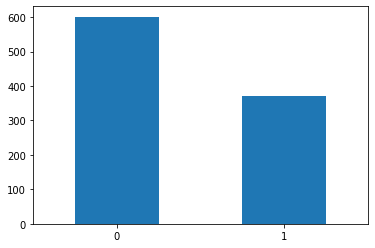

In [71]:
# Посмотрим на распределение целевого признака
y_train.value_counts().plot(kind='bar', rot=0)
plt.show()

#### Обработка данных

In [72]:
print(X_train.columns, X_test.columns)

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий',
       'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'акционные_покупки_категория'],
      dtype='object') Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий',
       'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'акционные_покупки_категория'],
      dtype='object')


In [73]:
# сделаем списки с названими признаков:
ohe_columns = [
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

ord_columns = [
    'акционные_покупки_категория'
]

num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_препредыдущий',
    'выручка_текущий',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
]

In [74]:
# Настроим первый этап, OHE-кодирование - заменим пропуски на самое частое значение
# закодируем категориальные признаки в бинарные
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



Стоит настроить работу энкодера OneHotEncoder на работу с неизвестными значениями признаков - сейчас энкодер "при встрече с неизвестной категорией" (это может случиться в проде) - будет выбрасывать ошибку. Для непрерывности процесса моделирования **следует обязательно** настроить параметр **handle_unknown='ignore'**, чтобы новые, ранее неизвестные (на этапе обучения модели) значения признаков игнорировались и не включались в итоговую матрицу. Когда ты "включишь" параметр **handle_unknown='ignore'**, то параметра **drop='first'** рядом с ним быть НЕ ДОЛЖНО.

---
Почему параметра **drop='first'** НЕ ДОЛЖНО быть рядом с **handle_unknown='ignore'**? 
Во-первых, эти 2 параметра не работают вместе на той версии scikit-learn (0.24), которая развернута сейчас на Платформе. 
Во-вторых, при их одновременном использовании будет наблюдаться следующая проблема:  и пропущенная (dropped) первая категория, и любые неизвестные категории будут кодироваться одинаково - вектором из всех нулей. Соответственно станет невозможным различить их после трансформации признаков.

ВАЖНО: прошу тебя аналогичные моменты исправить и ниже (если подобные ошибки встречаются) - на следующей итерации посмотрю этот момент.
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

In [75]:
# Следующий этап, переходим к Ordinal-кодированию, заменяем пропуски на самые частые значения
# Кодируем категорияальные признаки в числовой формат, понятный МО 
# После кодирования заполняем пропуски самым частым значением 
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>



OrdinalEncoder у тебя настроен на работу с неизвестными категориями.
</div>

In [76]:
# Собираем дальше все этапы предобработки:
# ohe - категориальные признаки
# ord - порядковые признаки
# num - масштабируем числовые признаки
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

**Использование трансформеров и пайплайнов - СУПЕР!**
    
---
Преимущества использования трансформеров:

1. **Гибкость и модульность**: Трансформеры позволяют разбить сложные операции по предобработке данных на более мелкие и легко управляемые компоненты. Это делает код более читаемым и модульным.

2. **Переиспользование**: Трансформеры могут быть повторно использованы на разных этапах анализа данных и построения моделей. Например, ты можешь создать трансформер для нормализации данных и использовать его как в обучении модели, так и на этапе инференса.

3. **Работа с разными типами данных**: Трансформеры могут обрабатывать различные типы данных, включая текст, изображения и числовые значения. Это позволяет тебе создавать единые интерфейсы для предобработки разнообразных данных.

Преимущества использования пайплайнов:

1. **Структурированность**: Пайплайны помогают организовать последовательность шагов обработки данных, начиная с загрузки и заканчивая подготовкой к обучению модели. Это обеспечивает структурированность и позволяет легко вносить изменения.

2. **Поддержание кода**: Пайплайны сокращают вероятность ошибок и упрощают поддержание кода. Отслеживание последовательности операций делает процесс отладки и оптимизации более прозрачным.

3. **Масштабируемость**: Пайплайны могут быть легко расширены новыми этапами обработки данных. Это позволяет добавлять новые операции без переписывания всего кода.

Объединение трансформеров и пайплайнов позволяет создавать чистые, структурированные и гибкие рабочие процессы для подготовки данных. Например, ты можешь создать трансформеры для преобразования текстовых данных и числовых значений, а затем построить пайплайн, который последовательно применяет эти трансформеры и завершается обучением модели. Это существенно упростит управление и анализ данных перед обучением моделей машинного обучения.

Несколько ссылок (*нужен vpn для подключения к сайтам + возможно понадобиться поиском поискать названия статей - если они были перемещены*), которые позволят погрузиться в тему:

- [трансформеры](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) и [пайплайны](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) для организации предобработки (кодирования, масштабирования) и модели
- применение пайплайна [A Basic Introduction to Pipelines in Scikit Learn](https://towardsdatascience.com/a-basic-introduction-to-pipelines-in-scikit-learn-bd4cee34ad95)
- большой гайд как можно комбинировать разные этапы предобработки [Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html)
- или можно написать свой класс-трансформер [Custom Transformers and Pipelines in Python](https://towardsdatascience.com/custom-transformers-in-python-part-ii-6fe111fc82e4)
</div>
</div>


In [77]:
# Финалим, собираем пайплайн. Пока прописываем древо дефолтно, дальше будем перебирать.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [78]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [79]:
#Запускаем поиск рандомный 
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

### Метрика ROC AUC выбрана потому, что:
 - устойчиво работает при дисбалансе классов, который у нас имеется
 - оценивает качество ранжирования модели 
 - не зависит от выбранного порога вероятности, который пришлось бы искать.
 - Таким образом, она является оптимальной метрикой для нашей ситуации

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>Добавил выше обоснование. 


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Да, отлично, исправлено.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



Не вижу обоснования выбора и использования конкретной метрики.
    
</div>

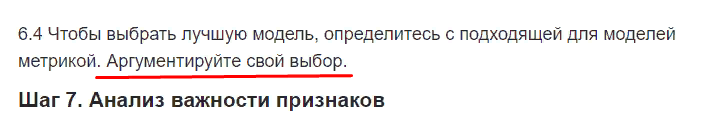

In [80]:
# Обучаем
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeli...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [81]:
# Выводим предметные итоги:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(ste

<div class="alert alert-warning">
<b>Комментарий 👉</b>

**Метрика лучшей модели на тренировочной выборке** - это НЕ результат на тренировочной выборке. Это результат на кросс-валидации. На тренировочной выборке оценка была бы, если бы это было: 
    
        model.fit(train).predict(train)
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь отлично: подобрали для всех наших моделей лучшие гиперпараметры.

После того, как гиперпараметры на кросс-валидации подобраны - мы должны проверить лучшую модель на тестовых данных. По результатам тестирования на тесте (сорри за тавталогию) выбираем модель, которую сможем передать в продакшн.</div>

In [82]:
# проверим работу модели на тестовой выборке
# и сделаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь хорошо. Расчёт ROC-AUC выполнен верно, через предсказанную вероятности класса 1. Здесь большой процент ошибок я часто вижу (коллеги делают расчет передавая вторым параметром не вероятность а признаки тестовой выборки). 
    
Площадь под ROC-кривой (Area Under Curve – площадь под кривой, Receiver Operating Characteristic – рабочая характеристика приёмника ... пришло из области радиоэлектроники) – это метрика оценки для задач бинарной классификации. ROC-кривая показывает зависимость между долей верно классифицированных объектов положительного класса и долей ложноположительных объектов. Ну и сама площадь под ROC-кривой является мерой качества классификатора: чем выше значение AUC (Area Under Curve), тем лучше качество классификации конкретной модели. Наш глаз и мозг устроены так, что мы очень хорошо видим геометрическую разницу (в данном случае площадей).
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь отлично: проверили "качество" нашей лучшей модели на тестовых данных и поняли что можем запустить её в промышленную эксплуатацию!
</div>

In [83]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')


Метрика F1-score на тестовой выборке: 0.9


### Вывод: 
- Мы перебрали 4 модели(KNN, Decision Tree, SVC, Logistic Regression), самая эффективаная - модель логистической регрессии.
- Лучшие параметры: LogisticRegression(C=4, penalty='l1', random_state=42,solver='liblinear')
- Ее метрика ROC_AUC на тренировочной выборке: 0.91
- Эта же мтерка на тестовой выборке = 0.89
- F1-score на тестовой равна 0.85. 
- Поскольку классы несбалансированы, метрика F1-score была рассчитана с усреднением macro, чтобы одинаково учитывать качество классификации каждого класса
- Это достоточно хорошие  результаты, модель можно использовать. 

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Для проверки модели на адекватность можно использовать DummyClassifier (из библиотеки sckit-learn).
    
p.s. (дополнительно, на перспективу!): можно было бы построить Confusion Matrix, чтобы детально посмотреть где ошибаются модели. Подробнее о Confusion Matrix здесь: https://neptune.ai/blog/evaluation-metrics-binary-classification     
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Раздел - СУПЕР! Пайплайны, транфсофрмеры - современный технологичный способ упаковки кода моделей и подбора гиперпараметров (ГП). Метрика проекта также выбрана и её использование обосновано.
</div>

## Анализ важности признаков

/opt/conda/lib/python3.9/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


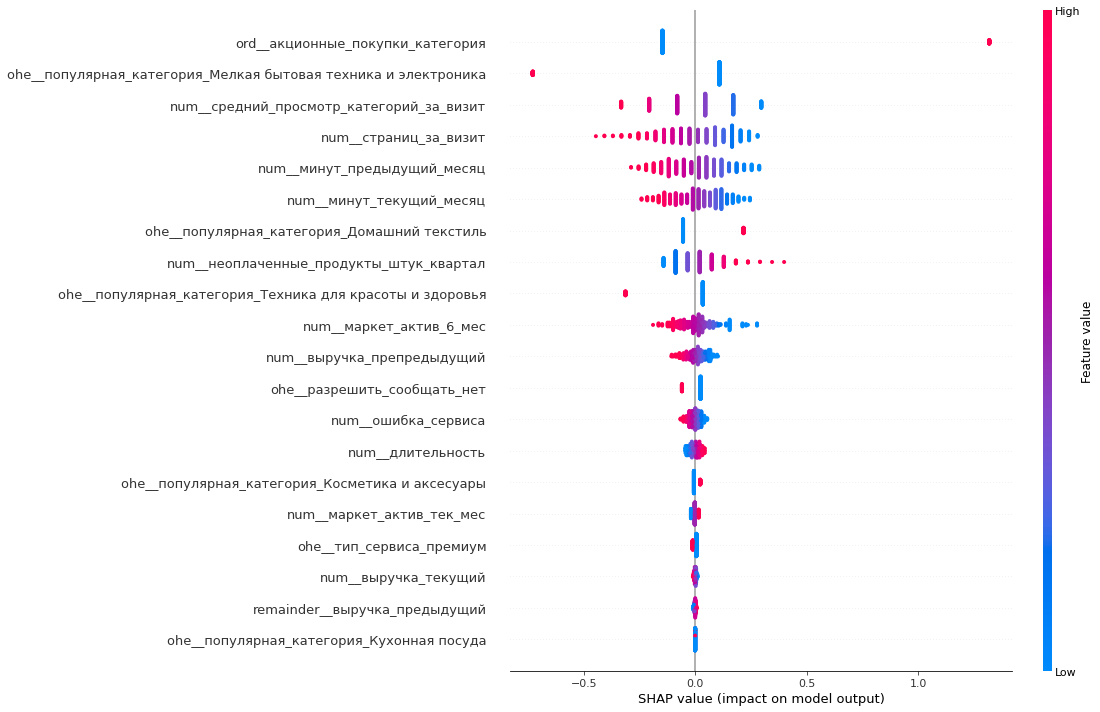

In [84]:
# Преобразуем обучающие данные с препроцессором
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

# Получаем модель из пайплайна
model = randomized_search.best_estimator_.named_steps['models']

# Создаем объяснитель
explainer = shap.LinearExplainer(model, X_train_2, feature_perturbation="interventional")

# Преобразуем тестовые данные
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

# Получаем имена признаков
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2_df = pd.DataFrame(X_test_2, columns=feature_names)

# Вычисляем значения SHAP
shap_values = explainer.shap_values(X_test_2)

# Строим диаграмму важности признаков
shap.summary_plot(shap_values, X_test_2_df, feature_names=feature_names,plot_size=(16, 10))

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец, здесь ты делаешь то, что я редко обычно встречаю в проектах (я про визуализацию признаков, которые модель "посчитала" важными. Почему их анализ важен и полезен (несколько причин, почему важно тщательно "рассматривать" признаки):

1. **Информативность**: Признаки содержат информацию, которая помогает модели делать предсказания. Некоторые признаки могут быть более информативными, чем другие, и могут иметь сильное влияние на результаты модели. Понимание, какие признаки являются наиболее информативными, поможет сосредоточить усилия на сборе и анализе этих признаков, что в конечном итоге может привести к лучшим предсказаниям модели.

2. **Устранение шума и избыточности**: Некоторые признаки могут содержать шумовую или избыточную информацию, которая может негативно повлиять на работу модели. Анализ и отсев таких признаков помогут улучшить качество модели, устранить возможное переобучение и улучшить ее способность обобщать данные.

3. **Раскрытие взаимосвязей**: Изучение признаков может помочь обнаружить скрытые взаимосвязи и зависимости в данных. Например, два признака могут быть слабо информативными сами по себе, но в комбинации могут образовывать сильный предиктор. Исследование и понимание взаимосвязей между признаками может привести к созданию более сложных, но более мощных моделей.

4. **Сокращение размерности**: Некоторые наборы данных могут содержать большое количество признаков, и это может стать проблемой для обучения моделей. Сокращение размерности путем отбора наиболее важных признаков позволяет сократить вычислительную сложность, снизить вероятность переобучения и улучшить интерпретируемость модели.

5. **Интерпретируемость**: Понимание важности признаков также помогает интерпретировать результаты модели. Если мы знаем, какие признаки оказывают наибольшее влияние на предсказания, мы можем сделать более осознанные выводы и принимать меры на основе результатов   
</div>


### Вывод:
- Самым сильновлияющим стал признак 'акционные покупки - категория'. Есть у меня подозрение, что я зря его сделал категориальным. Надеюсь, ревьюер меня поправит если что. 
- Чуть меньшее влияние оказывают признаки: Категория мелкая бытовая техника,домашний текстиль исредний просмотр категорий за визит.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

**Самым сильновлияющим стал признак 'акционные покупки - категория'. Есть у меня подозрение, что я зря его сделал категориальным** - не вижу здесь проблем.
</div>

## Сегментация покупателей:


### У нас есть разбиение на тех клиентов у кого снизилась покупательская активность и на тех, у кого осталась на прежнем уровне. Соеденим их с данными о прибыльности.



<div class="alert alert-warning">
<b>Комментарий 👉</b>

Сразу скажу, что в этом разделе ошибок быть не может ))) Всё потому, что грамотный и вдумчивый исследователь данных (*а ты собственно к этому моменту доказываешь, что визуализацией данных владеешь + видением трендов и закономерностей (на основе этих графиков) обладаешь*) - с почти 100%ой вероятностью **СМОЖЕТ** провести исследование групп покупателей, да и сделать конкретные предложения по работе с этими сегментами для увеличения профита Компании.

Но тем не менее, несмотря на то, что анализ клиентов в этом разделе не определяется жёстко в ТЗ - позволю  накидать несколько моментов про то, как это вижу я:
    
1. Выбираем сегмент и объясняем почему мы его выбрали. Тут делаем упор на бизнес - составляющую (мы ведь всем этим занимаемся не в сферическом вакууме, а для повышения экономической эффективности) и логику. Пример:

    "нас интересуют богатенькие клиенты, поэтому...", "нас интересуют те для кого модель предсказала высокую вероятность ухода, потому что...", "нас интересуют богатенькие и уходящие, потому что..."

- Или ориентируемся на результаты оценки важности признаков. Пример:

    "акционные покупки не показали высокую значимость на графиках shap, но если приглядеться, то yf графике beeswarm мы видим очень четкое разделение: высокие акционные покупики - высокая вероятность снижения, значит мы можем..." 

2.  У нас есть файл money, в нем содержится важная информация о прибыльности клиентов. Это наверно самый важный параметр с точки зрения бизнеса: клиент может много покупать, но прибыльность от него будет небольшой, или наоборот клиент может мало покупать, но он покупает товары которые продавать магазину выгодно. Чувствуешь разницу?! Стоит обогатить наши данные этой информацией
    
3. Используем результаты моделирования, а иначе зачем мы все это делали?!  Можно использовать результат predict_proba посмотрев на уверенность модели в том что клиент снижает активность - вот и вариант сегментации.  Можно использовать модель как источник вдохновения для выбора признаков (если модель считает признак важным для прогноза активности, то логично посмотреть на него поближе). Можно приглядеться на графики shap.beeswarm, увидев там что то интересное. Или можно все это использовать вместе.  Кстати можно подглядеть внутрь моделей не только с помощью shap, но и построить [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) и там подсмотреть  комбинацию признаков с конкретными порогами, сделав упор на признаки - причины. Например проанализировав   plot_tree мы можем увидеть что для такой то группы товаров, при таком то значении акционных покупок и при таком то сервисе, высока доля не снижающих активность клиентов (ничего такого на самом деле нет, это просто пример). И мы сможем сделать более сложные маркетинговые предложения.

4. После выбора сегмента мы можем посмотреть усредненный портрет клиентов попавших в него, но сами по себе цифры нас не интересуют, нас интересует разница с клиентами не попавшими в сегмент. поэтому стоит проанализировать сегмент, указать на его отличия от остальных. для этого отлично подойдут графики countplot/pie (для категориальных) и гистограмму или boxplot (для количественных), а разбивке "наш сегмент" - "не наш сегмент"

5. И в конце составляем индивидуальные маркетинговые предложения для выбранного сегмента - иначе для чего мы всё это делали!?  При этом  выводы не должны быть слишком общими, напрмиер предложение "предложить акцию", это слишком общее предложение, лучше указать для кого, по какой группе товаров итп итд
    
p.s. еще можно посмотреть на динамику выручки по месяцам, в группировке по категориальным признакам (популярная категория, тип сервиса, разрешить сообщить), возможно тут получится увидеть что то интересное и сделать какие то маркетинговые предложения. Отслеживание динамики, как и сравнение, отличный способ найти в данных что то интересное.
</div>

In [85]:
# Соберем результаты
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [86]:
# Cохранимся и объеденимся
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_остаться_активным'] = y_test_proba
X_train_full['вероятность_остаться_активным'] = y_train_proba
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)
df_full = pd.concat([X_train_full, X_test_full])
df_full['активность_bin'] = y_all
df_full = df_full.join(money)

In [87]:
df_full.columns

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий',
       'выручка_текущий', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'акционные_покупки_категория', 'вероятность_остаться_активным',
       'активность_bin', 'id', 'прибыль'],
      dtype='object')

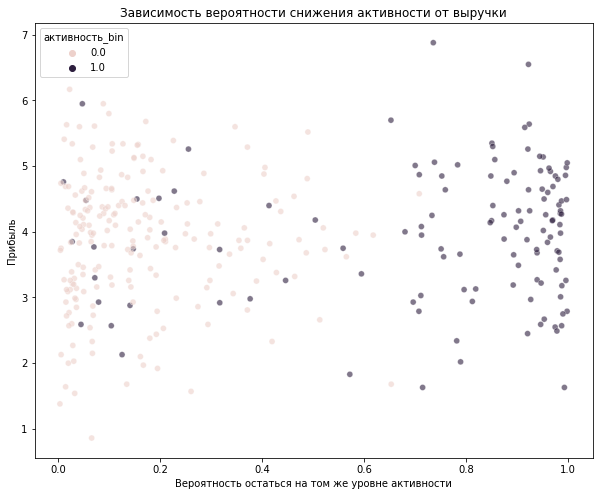

In [88]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_остаться_активным', hue=y_test, alpha=0.6)
plt.xlabel('Вероятность остаться на том же уровне активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

####  Наглядно видно, что модель хорошо предсказывает. Но прибыль напрямую не коррелирует с вероятностью снижения.  Есть клиенты с высокой прибылью, но при этом и предсказание модели, и по факту их активность снизилась.Имеем биномиальное распределение (0 или 1) . Нам необходимо сфокусироваться на клиентах с высокой вероятностью снижения. Тех, кто близок к снижению активности(значения ниже 0,5) и тех кто приносит прибыль(значения выше 3)

In [89]:
valuable_at_risk = df_full[
    (df_full['вероятность_остаться_активным'] < 0.5) &
    (df_full['прибыль'] > 3)
]

print(f"Количество клиентов в сегменте: {len(valuable_at_risk)}")
display(valuable_at_risk.describe())

Количество клиентов в сегменте: 716


,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий_месяц,минут_текущий_месяц,вероятность_остаться_активным,активность_bin,id,прибыль
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,713.000000,716.000000,716.000000
mean,4.586313,4.002793,591.237430,3.659218,2.273743,4.350559,9.885475,4943.502793,4930.335894,5182.623045,15.184358,14.840782,0.148636,0.378682,216175.335196,4.307975
std,0.832341,0.679360,254.206385,1.287296,1.501676,1.967217,3.432589,318.754532,617.862598,793.743946,3.383147,3.946114,0.127754,0.485399,272.584572,0.786336
min,1.500000,3.000000,121.000000,1.000000,0.000000,0.000000,3.000000,4339.000000,3111.000000,2952.200000,7.000000,4.000000,0.002772,0.000000,215350.000000,3.030000
25%,4.000000,4.000000,386.250000,3.000000,1.000000,3.000000,7.000000,4702.250000,4528.625000,4721.500000,13.000000,12.000000,0.046849,0.000000,215958.750000,3.700000
50%,4.400000,4.000000,594.000000,4.000000,2.000000,4.000000,10.000000,4940.500000,4973.250000,5110.450000,15.000000,15.000000,0.105358,0.000000,216178.500000,4.260000
75%,5.300000,4.000000,795.250000,5.000000,3.000000,6.000000,12.000000,5176.000000,5339.625000,5607.700000,18.000000,18.000000,0.209137,1.000000,216406.250000,4.820000
max,6.600000,5.000000,1061.000000,6.000000,7.000000,9.000000,20.000000,5663.000000,6588.500000,7557.000000,23.000000,23.000000,0.497699,1.000000,216646.000000,7.020000


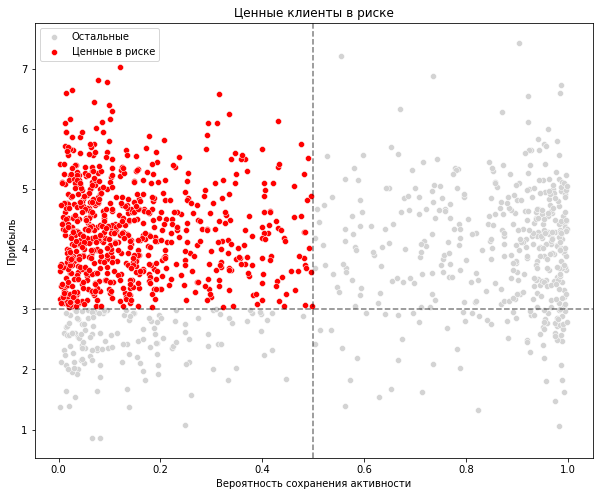

In [90]:
# Отлтично, визуализируем 
plt.figure(figsize=(10, 8))

# Общий фон — все клиенты
sns.scatterplot(data=df_full, x='вероятность_остаться_активным', y='прибыль', color='lightgray', label='Остальные')

# Целевой сегмент
sns.scatterplot(data=valuable_at_risk, x='вероятность_остаться_активным', y='прибыль', color='red', label='Ценные в риске')

plt.axvline(0.5, linestyle='--', color='black', alpha=0.5)
plt.axhline(3, linestyle='--', color='black', alpha=0.5)

plt.xlabel('Вероятность сохранения активности')
plt.ylabel('Прибыль')
plt.title('Ценные клиенты в риске')
plt.legend()
plt.show()

In [91]:
# добавим сегмент ценных стабильных клиентов, у которых низкая вероятность снижения
valuable_stable = df_full[
    (df_full['вероятность_остаться_активным'] >= 0.5) &
    (df_full['прибыль'] > 3)
]

In [92]:
# и остальные 
others = df_full[~df_full.index.isin(valuable_at_risk.index) & ~df_full.index.isin(valuable_stable.index)]


In [93]:
print("🧮 Средние значения признаков тех, кто в риске:")
display(valuable_at_risk.describe().T[['mean', 'std']])
print("🧮 Средние значения признаков тех, кто стабилен и ценен:")
display(valuable_stable.describe().T[['mean', 'std']])


🧮 Средние значения признаков тех, кто в риске:


,mean,std
маркет_актив_6_мес,4.586313,0.832341
маркет_актив_тек_мес,4.002793,0.679360
длительность,591.237430,254.206385
средний_просмотр_категорий_за_визит,3.659218,1.287296
неоплаченные_продукты_штук_квартал,2.273743,1.501676
ошибка_сервиса,4.350559,1.967217
страниц_за_визит,9.885475,3.432589
выручка_препредыдущий,4943.502793,318.754532
выручка_предыдущий,4930.335894,617.862598
выручка_текущий,5182.623045,793.743946


🧮 Средние значения признаков тех, кто стабилен и ценен:


,mean,std
маркет_актив_6_мес,3.587569,1.007746
маркет_актив_тек_мес,4.013812,0.707950
длительность,629.027624,235.621285
средний_просмотр_категорий_за_визит,2.464088,1.136200
неоплаченные_продукты_штук_квартал,4.038674,2.206424
ошибка_сервиса,3.850829,1.916501
страниц_за_визит,4.698895,2.537355
выручка_препредыдущий,4622.549724,260.869055
выручка_предыдущий,4954.350829,826.436748
выручка_текущий,5315.901934,900.025260


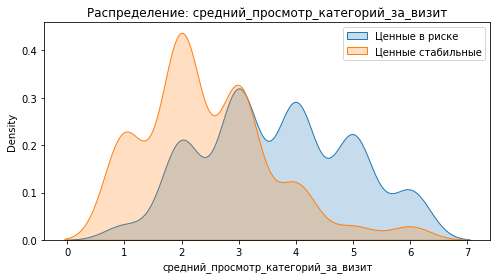

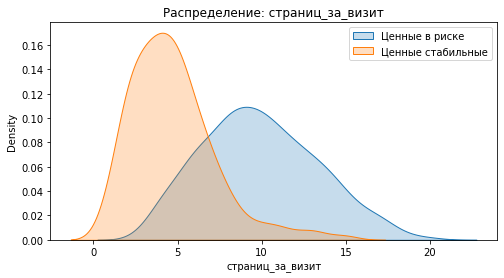

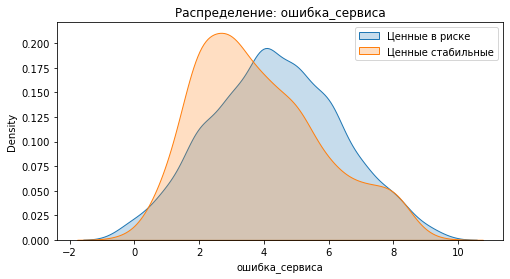

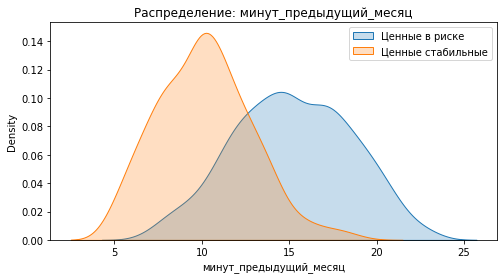

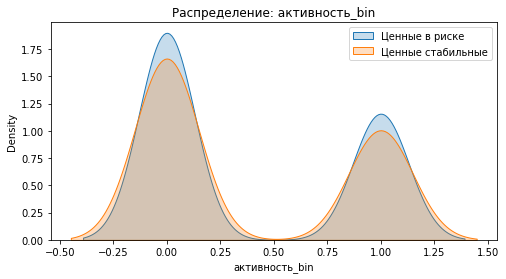

In [94]:
key_features = [
    'средний_просмотр_категорий_за_визит',
    'страниц_за_визит',
    'ошибка_сервиса',
    'минут_предыдущий_месяц',
    'активность_bin'
]

for feature in key_features:
    if feature in df_full.columns:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(valuable_at_risk[feature], label='Ценные в риске', fill=True)
        sns.kdeplot(valuable_stable[feature], label='Ценные стабильные', fill=True)
        plt.title(f'Распределение: {feature}')
        plt.legend()
        plt.show()
    else:
        print(f"[⚠️ Пропущено] Признак отсутствует в данных: {feature}")

### Вывод, исходя из данных, мы можем сделать выводы:
- Клиенты в риске изучают меньше категорий, у них неже вовлеченность. Это может быть маркером.
- Количество просмотренных страниц за визит так же явно меньше. 
- Проводят меньше времени за платформой. 
- Стабильные клиенты чаще получают маркетинг. 

### Рекомендации бизнесу по работе с рисковым сегментом:
- Активизировать маркетинговые кампании
- Оптимизировать путь к покупке,выяснить причину неоплачиваемости товаров.
- Увеличить вовлеченность клиентов.
- Поработать с категориями товаров.

## Общий вывод
В рамках данного проекта решалась задача определения покупателей интернет-магазина «В один клик», чья активность может снизиться. Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Что было сделано:

####  Осуществлена загрузка 4х датасетов с данными о компании и первоначальное знакомство с ними

#### Проведена предобработка данных:
- Привели все столбцы к единообразию
- Убрали ошибку в категориях
- Убедились что нет дубликатов

#### Проведен исследовательский анализ данных, в рамках его:
- Познакомились с данными визуально, как с категориальными, так и с количественными. 
- Распределения нормальные, подозрений не вызывают. Хотя есть местами выбросы. 
- Убрали трех клиентов, у которых покупательская активность менее трех месяцев и один явный выброс. 

#### Объеденили 3 таблицы для дальшенего МО. 
- Мы создали общую сводную таблицу где мастер-записью является id клиента, а каждая колонка это один из периодов выручки.
- Так же поступаем с таблицей где есть учет времени проведенного на сайте пользователем. 
-  Далее объединяем это все в один датасет.

#### Провели корреляционный анализ:
- Устранили мультиколлинеарность, убрав один из более старых признаков. 
- Тк датасет не большой, оставили все признаки, даже с маленькой корреляцией.

#### Собрали пайплайн данных
##### Использовали модели: 
- Модель логистической регрессии
- Метод опорных векторов
- Метод k-ближайших соседей
- Дерево решений
##### Действовали по плану:
- Закодируем целевой признак - покупательская_активность.  
- Сделаем из акционных покупок - категориальный признак.
- Разделим данные на тренировочную и тестовую выборки.
- Подготовим данные: отдельно обработаем количественные, отдельно категориальные. 
- Масштабируем данные
- Обучим модель, посмотрим метрики, выберем самую эффективную модель.
##### По итогу:
- Мы перебрали 4 модели(KNN, Decision Tree, SVC, Logistic Regression), самая эффективаная - модель логистической регрессии.
- Лучшие параметры: LogisticRegression(C=4, penalty='l1', random_state=42,solver='liblinear')
- Ее метрика ROC_AUC на тренировочной выборке: 0.91
- Эта же мтерка на тестовой выборке = 0.89
- F1-score на тестовой равна 0.85. 
- Поскольку классы несбалансированы, метрика F1-score была рассчитана с усреднением macro, чтобы одинаково учитывать качество классификации каждого класса
- Это достоточно хорошие  результаты, модель можно использовать. 

#### Проанализировали важность признаков: 
- Самым сильновлияющим стал признак 'акционные покупки - категория'.
- Чуть меньшее влияние оказывают признаки: Категория мелкая бытовая техника,домашний текстиль исредний просмотр категорий за визит.

#### Сегментировали пользователей
- Добавили к единой таблице еще одну, с прибылью.
- Сначала визуализировали и еще раз наглядно убедились в точности модели.
- Далее обратили внимание, что активность слабо коррелирует с прибылью
- Есть клиенты с высокой прибылью, но при этом и предсказание модели, и по факту их активность снизилась.Имеем биномиальное распределение (0 или 1) . 
- Решили, что нам необходимо сфокусироваться на клиентах с высокой вероятностью снижения. Тех, кто близок к снижению активности(значения ниже 0,5) и тех кто приносит прибыль(значения выше 3)¶



# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b> 

1. (28) Ряд признаков в наших данных имеет дискретную природу (например это: 'Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', ... (*не привожу все названия из данных*)). Для графического анализа дискретных признаков нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать **sns.countplot** или **.plot(kind='bar')**. Ты же для визуализации их используешь гистограмму.
    
2. (36) Сколько в наших данных признаков с нормальным распределением? Следует выполнить подобную "строгую" проверку (с использованием статистического теста). В любом случае голословное (БЕЗ проверки) утверждение "о нормальности" - это не до конца выполненное аналитиком данных исследование.    
    
3. (44) Полного и всеобъемлющего финального вывода по исследовательскому анализу данных (EDA) нет.    
    
4. (49) Нормально ли распределены наши признаки? Если нет, то каким методом надо считать коэффициенты корреляции?        
    
5. (51) Кодирование нужно делать только с применением обучаемых трансформеров. Для кодирования целевого признака нужно использовать LabelEncoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html.    
    
6. (60) Стоит настроить работу энкодера OneHotEncoder на работу с неизвестными значениями признаков - сейчас энкодер "при встрече с неизвестной категорией" (это может случиться в проде) - будет выбрасывать ошибку. 
    
7. (65) Не вижу обоснования выбора и использования конкретной метрики.        
</div>

Эти моменты требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>Все поправил. Перед каждым красным комментарием, добавил синий свой. Большое спасибо за такое доскональное ревью с большим количеством полезной информации!


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Александр, был рад работать с тобой совместно над проектом! ПРОЕКТ ПРИНЯТ!
    
p.s. загляни сейчас в эл/почтовый ящик ...    
</div>